https://github.com/dav1ddramb for https://t.me/halftimestat

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
from bs4 import BeautifulSoup
from sklearn.neighbors import KernelDensity
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os

headers = {'User-Agent': 
       ('Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko)' 
        'Chrome/47.0.2526.106 Safari/537.36')}

In [3]:
def league_name_converter(raw_name):
    name_split = raw_name.split('-') # raw_name[:raw_name.find('.')].split('-')
    pretty_name = ' '.join([word.capitalize() for word in name_split])
    return pretty_name

## The most overpaying and underpaying teams
MV of signings and actual expenditure difference

In [3]:
# transfers, MV of signings and actual expenditure difference
transf_mv = []

league_url_format= '''
https://www.transfermarkt.com/{}/transfers/wettbewerb/{}/plus/?saison_id={}&s_w=&leihe=0&intern=0
''' # exclude loans and internal transfers


league_name_id_list = [
    ('serie-a', 'IT1'), ('premier-league', 'GB1'), ('bundesliga', 'L1'), ('laliga', 'ES1'), ('ligue-1', 'FR1'),
]

for league_name, league_id in league_name_id_list:
    for season_id in range(2023, 2023+1):
        league_url = league_url_format.format(league_name, league_id, season_id)

        res = requests.get(league_url, headers=headers)
        cont = res.content
        tree = BeautifulSoup(cont, 'html.parser')
        n_clubs = len(tree.find_all(
            'h2', {'class': 'content-box-headline content-box-headline--inverted content-box-headline--logo'})
        )
        
        ### lists of mvs and fees
        mv_sum_list = tree.find_all('span', {'class': 'transfer-zusatzinfo-wert'})
        ins_fees_sum_list = tree.find_all('span', {'class': 'transfer-einnahmen-ausgaben redtext'})
        outs_fees_sum_list = tree.find_all('span', {'class': 'transfer-einnahmen-ausgaben greentext'})
        
        ### ### workaround Tottenham no transfer season ###
        if league_name=='premier-league' and season_id==2018:
            mv_sum_list.insert(
                4, # Tottenham's expected ins mvs position
                BeautifulSoup(
                    '<span class="transfer-zusatzinfo-wert">Total market value of arrivals: -</span>', 
                    'html.parser'
                )
            )
            
            ins_fees_sum_list.insert(
                2, 
                BeautifulSoup('<span class="transfer-einnahmen-ausgaben redtext">Expenditure: -</span>', 'html.parser')
            )
        ### ### ###

        print(league_name, season_id, n_clubs)
        for club_i in range(n_clubs):
            club_name = tree.find_all(
                'h2', {'class': 'content-box-headline content-box-headline--inverted content-box-headline--logo'}
            )[club_i].text.strip()
            # print(club_name, end=', ')
            
            ## market values
            ins_mv_sum = str(mv_sum_list[2*club_i].text.strip())
            outs_mv_sum = str(mv_sum_list[2*club_i+1].text.strip())

            # actual fees
            ins_sum = str(ins_fees_sum_list[club_i].text.strip())
            outs_sum = str(outs_fees_sum_list[club_i].text.strip())


            transf_mv.append(
                [league_name, season_id, club_name, ins_mv_sum, outs_mv_sum,ins_sum, outs_sum]
            )

serie-a 2023 20
premier-league 2023 20
bundesliga 2023 18
laliga 2023 20
ligue-1 2023 18


Note: the data is not correcct everywhere, especially, the more historical one: Manchester CCity 2014 signings' MV is superlow, it is different in the plaer's page

ANSWER: The MV shows the current MV of the player, see Hazard's 2019 Chelsea transfer, shows MV 0f 5m while it was 150

In [4]:
transf_mv_df = pd.DataFrame(
    transf_mv, 
    columns=['league_name', 'season_start_y', 'club_name', 'ins_mv_sum_raw', 'outs_mv_sum_raw', 'ins_sum_raw', 'outs_sum_raw']
)


def format_fee_oom(fee_raw):
    ''' format fee order of magnitude '''
    if fee_raw=='-':
        return 0
    elif fee_raw[-1]=='k':
        return 0.001*float(fee_raw.strip('€k'))
    else:
        return float(fee_raw.strip('€m'))
    

# format fees
transf_mv_df['ins_mv_sum'] = transf_mv_df['ins_mv_sum_raw'].apply(
    lambda x: x.replace('Total market value of arrivals: ', '')
)
transf_mv_df['ins_mv_sum_int'] = transf_mv_df['ins_mv_sum'].apply(format_fee_oom)

transf_mv_df['outs_mv_sum'] = transf_mv_df['outs_mv_sum_raw'].apply(
    lambda x: x.replace('Total market value of departures: ', '')
)
transf_mv_df['outs_mv_sum_int'] = transf_mv_df['outs_mv_sum'].apply(format_fee_oom)


transf_mv_df['ins_sum'] = transf_mv_df['ins_sum_raw'].apply(
    lambda x: x.replace('Expenditure: ', '')
)
transf_mv_df['ins_sum_int'] = transf_mv_df['ins_sum'].apply(format_fee_oom)

transf_mv_df['outs_sum'] = transf_mv_df['outs_sum_raw'].apply(
    lambda x: x.replace('Income: ', '')
)
transf_mv_df['outs_sum_int'] = transf_mv_df['outs_sum'].apply(format_fee_oom)

transf_mv_df = transf_mv_df.drop(columns=['ins_mv_sum', 'outs_mv_sum', 'ins_sum', 'outs_sum'])

In [5]:
# the actual overpaying and overselling

transf_mv_df['overpay_ratio'] = transf_mv_df['ins_sum_int'] / transf_mv_df['ins_mv_sum_int']
transf_mv_df['overpay_diff'] = transf_mv_df['ins_sum_int'] - transf_mv_df['ins_mv_sum_int']

transf_mv_df['oversell_ratio'] = transf_mv_df['outs_sum_int'] / transf_mv_df['outs_mv_sum_int']
transf_mv_df['oversell_diff'] = transf_mv_df['outs_sum_int'] - transf_mv_df['outs_mv_sum_int']

In [7]:
# transf_mv_df.to_csv('transf_mv_df_big5_2223.csv')

In [107]:
transf_mv_df[
    (transf_mv_df.league_name=='premier-league')
    &(transf_mv_df.season_start_y==2018)
]

,league_name,season_start_y,club_name,ins_mv_sum_raw,outs_mv_sum_raw,ins_sum_raw,outs_sum_raw,ins_mv_sum_int,outs_mv_sum_int,ins_sum_int,outs_sum_int,overpay_ratio,overpay_diff,oversell_ratio,oversell_diff


In [179]:
# transf_mv_df[:].sort_values('overpay_diff') # 'overpay_ratio'
display_df = transf_mv_df[:].sort_values('overpay_ratio', ascending=False).head(15).reset_index()

fig = px.bar(
    display_df, x=display_df.index, y='overpay_ratio', text=display_df['overpay_diff'].round(1),
    color=display_df['league_name'].apply(league_name_converter), 
    color_discrete_sequence=px.colors.qualitative.G10,
    title='The most overpaying clubs, BIG 5 leagues 23/24', width=950, height=600,
    labels={
        '_index': '', 'color': '', 'overpay_ratio': '€ spent / market value ratio (bought players)',
    }
)

fig.update_traces(textangle=0)
fig.update_layout(
    font=dict(size=13),
    xaxis = dict(tickmode='array', tickvals=display_df.index, ticktext=display_df['club_name']),
)
fig.add_annotation(
    x=0.95, y=0.9, xref='paper', yref='paper',
    text='Numbers inside bars indicate <b>€ millions overpaid</b><br>(difference between market value & spend of bought players)', 
    showarrow=False, font=dict(family="Courier New, monospace", size=16, color="black"),
    align="center", bgcolor="bisque", opacity=0.75
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

In [186]:
# transf_mv_df[:].sort_values('overpay_diff') # 'overpay_ratio'
display_df = transf_mv_df[:].sort_values('overpay_ratio', ascending=True).head(15).reset_index()

fig = px.bar(
    display_df, x=display_df.index, y='overpay_ratio', text=display_df['overpay_diff'].round(1),
    color=display_df['league_name'].apply(league_name_converter), 
    color_discrete_sequence=px.colors.qualitative.G10,
    title='The least overpaying clubs, BIG 5 leagues 23/24', width=950, height=600,
    labels={
        '_index': '', 'color': '', 'overpay_ratio': '€ spent / market value ratio (bought players)',
    }
)

fig.update_traces(textangle=0)
fig.update_layout(
    font=dict(size=14),
    xaxis = dict(tickmode='array', tickvals=display_df.index, ticktext=display_df['club_name']),
)
fig.add_annotation(
    x=0.025, y=0.95, xref='paper', yref='paper',
    text='Numbers inside bars indicate <b>€ millions overpaid</b><br>(difference between market value &<br>spend of bought players)', 
    showarrow=False, font=dict(family="Courier New, monospace", size=16, color="black"),
    align="center", bgcolor="bisque", opacity=0.75
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

In [164]:
# transf_mv_df[:].sort_values('oversell_diff') # 'oversell_ratio'
display_df = transf_mv_df[:].sort_values('oversell_ratio', ascending=False).head(15).reset_index()

fig = px.bar(
    display_df, x=display_df.index, y='oversell_ratio', text=display_df['oversell_diff'].round(1),
    color=display_df['league_name'].apply(league_name_converter), 
    color_discrete_sequence=px.colors.qualitative.G10,
    title='The best clubs at selling players, BIG 5 leagues 23/24', width=950, height=600,
    labels={
        '_index': '', 'color': '', 'oversell_ratio': '€ spent / market value ratio (sold players)',
    }
)

fig.update_traces(textangle=0)
fig.update_layout(
    font=dict(size=13),
    xaxis = dict(tickmode='array', tickvals=display_df.index, ticktext=display_df['club_name']),
)
fig.add_annotation(
    x=0.95, y=0.9, xref='paper', yref='paper',
    text='Numbers inside bars indicate<br><b>€ millions overreceived</b><br>(difference between market value & revenue of sales)', 
    showarrow=False, font=dict(family="Courier New, monospace", size=16, color="black"),
    align="center", bgcolor="bisque", opacity=0.75,
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

## Attack wins you matches, defence wis you titles

In [313]:
teams_df = pd.DataFrame()

for league_yyyy in range(2018, 2023): # [2021, 2022]:
    for league in ['Premier-League', 'La-Liga', 'Bundesliga', 'Serie-A', 'Ligue-1']:
        league_df = pd.read_csv(
            '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/{}-{}-{}_Teams.csv'.format(
                league_yyyy, league_yyyy+1, league
            )
        )
        league_df = league_df[
            ['squad', 'gk_games', 'gk_wins', 'gk_ties', 'gk_losses', 'goals', 'gk_goals_against', 
             'xg', 'gk_psxg', 'npxg', 'shots_on_target', 'gk_shots_on_target_against'] # 'xg_net', 'npxg_net',]
        ]

        league_df['league'] = league
        league_df['squad_season'] = league_df['squad'] + ', ' + str(league_yyyy)[2:] + '/' + str(league_yyyy+1)[2:]
        
        league_df['points'] = 3*league_df['gk_wins'] + league_df['gk_ties']
        league_df = league_df.sort_values('points', ascending=False).reset_index(drop=True)
        league_df['position'] = league_df.index + 1
        league_df['champion'] = league_df['position'] == 1
        league_df['champion_int'] = np.where(league_df['position'] == 1, 7.5, 1)
        
        league_df['max_shots'] = league_df['shots_on_target'].max()
        league_df['min_shots_against'] = league_df['gk_shots_on_target_against'].min()
        
        league_df['max_goals'] = league_df['goals'].max()
        league_df['min_goals_against'] = league_df['gk_goals_against'].min()

        teams_df = pd.concat([teams_df, league_df], axis=0)

In [314]:
teams_df.head()

,squad,gk_games,gk_wins,gk_ties,gk_losses,goals,gk_goals_against,xg,gk_psxg,npxg,...,league,squad_season,points,position,champion,champion_int,max_shots,min_shots_against,max_goals,min_goals_against
0,Manchester City,38.0,32.0,2.0,4.0,91.0,23.0,84.3,23.3,81.3,...,Premier-League,"Manchester City, 18/19",98.0,1,True,7.5,252.0,81.0,91.0,22.0
1,Liverpool,38.0,30.0,7.0,1.0,86.0,22.0,73.7,27.2,68.4,...,Premier-League,"Liverpool, 18/19",97.0,2,False,1.0,252.0,81.0,91.0,22.0
2,Chelsea,38.0,21.0,9.0,8.0,61.0,39.0,58.6,36.8,54.6,...,Premier-League,"Chelsea, 18/19",72.0,3,False,1.0,252.0,81.0,91.0,22.0
3,Tottenham,38.0,23.0,2.0,13.0,66.0,39.0,54.9,47.7,51.8,...,Premier-League,"Tottenham, 18/19",71.0,4,False,1.0,252.0,81.0,91.0,22.0
4,Arsenal,38.0,21.0,7.0,10.0,69.0,51.0,60.1,53.5,56.0,...,Premier-League,"Arsenal, 18/19",70.0,5,False,1.0,252.0,81.0,91.0,22.0


In [315]:
### absolute values
x_feat = 'shots_on_target' # 'goals'
y_feat = 'gk_shots_on_target_against' # 'gk_goals_against'

fig = px.scatter(
    teams_df, x=x_feat, y=y_feat, # position
    color='league', size='champion_int', custom_data=['squad_season'], # text='squad',
    title='Shots made and conceded, BIG 5 leagues, 2018-2023',
    labels={'shots_on_target': 'Shots on target by the team', 
        'gk_shots_on_target_against': 'Shots on target against',
       'position': 'Table<br>position'}
)

### hover text
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "squad: %{customdata[0]}",
    ])
)


######################################################
###### OUTLIERS NEED TO BE SUBSCRIPTED MANUALLY ######
######################################################

### outliers citing
outliers = teams_df.loc[
#     (teams_df.champion==True) |
    (teams_df.squad_season.str.contains('Paris S-G, 19/20')) | 
    (teams_df.squad_season.str.contains('Paris S-G, 22/23')) | 
    (teams_df.squad_season.str.contains('Juventus 19/20')) | 
    (teams_df.squad_season.str.contains('Manchester City, 22/23')) |
    (teams_df.squad_season.str.contains('Bayern Munich, 18/19')) |
    (teams_df.squad_season.str.contains('Manchester City, 18/19')) |
    (teams_df.squad_season.str.contains('Lille, 20/21')) |
    (teams_df.squad_season.str.contains('Bayern Munich, 21/22')),
    
    ['squad_season', x_feat, y_feat]
]

### add text to outliers using their (x,y) coordinates:
for p,x,y in outliers.itertuples(index=False):
    x_shift = 0
    y_shift = -20
    if 'Paris S-G, 22/23' in p or 'Juventus 19/20' in p or 'Bayern Munich, 21/22' in p:
        y_shift = 20
    if 'Manchester City, 18/19' in p:
        y_shift = 20

    fig.add_annotation(
        x=x, y=y,
        text=p,
        showarrow=False,
        xshift=x_shift,
        yshift=y_shift
    )



fig.add_annotation(
    x=0.95, y=0.95, xref='paper', yref='paper',
    text='Big circles indicate <br><b>league champions</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"), 
    align="center", bgcolor="snow", opacity=0.75)

fig.update_traces(textposition='top center')
fig.update_layout(
    {'plot_bgcolor': 'antiquewhite', 'paper_bgcolor': 'white'}, # 'plot_bgcolor': 'aquamarine'
    font=dict(size=14),
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

In [316]:
print(np.corrcoef(teams_df.goals, teams_df.position)[0, 1])
print(np.corrcoef(teams_df.gk_goals_against, teams_df.position)[0, 1])

print(np.corrcoef(teams_df.goals, teams_df.points)[0, 1])
print(np.corrcoef(teams_df.gk_goals_against, teams_df.points)[0, 1])


print(np.corrcoef(teams_df.shots_on_target, teams_df.position)[0, 1])
print(np.corrcoef(teams_df.gk_shots_on_target_against, teams_df.position)[0, 1])

print(np.corrcoef(teams_df.shots_on_target, teams_df.points)[0, 1])
print(np.corrcoef(teams_df.gk_shots_on_target_against, teams_df.points)[0, 1])

-0.7998806019675242
0.7854332595670066
0.8643939650745944
-0.7545502694037016
-0.7218449900812262
0.6782680489145078
0.805390574695506
-0.6285708250633514


In [317]:
print(np.corrcoef(teams_df.goals, teams_df.champion)[0, 1])
print(np.corrcoef(teams_df.gk_goals_against, teams_df.champion)[0, 1])


print(np.corrcoef(teams_df.shots_on_target, teams_df.champion)[0, 1])
print(np.corrcoef(teams_df.gk_shots_on_target_against, teams_df.champion)[0, 1])

0.46586031145813267
-0.34727856183500355
0.4458168764193637
-0.3217618744481872


In [320]:
print(teams_df[(teams_df.champion==True)&(teams_df.gk_goals_against==teams_df.min_goals_against)].shape)
print(teams_df[(teams_df.champion==True)&(teams_df.goals==teams_df.max_goals)].shape)

teams_df[
    (teams_df.champion==True)&
    (teams_df.gk_goals_against!=teams_df.min_goals_against)&
    (teams_df.goals!=teams_df.max_goals)
]

(16, 22)
(16, 22)


,squad,gk_games,gk_wins,gk_ties,gk_losses,goals,gk_goals_against,xg,gk_psxg,npxg,...,league,squad_season,points,position,champion,champion_int,max_shots,min_shots_against,max_goals,min_goals_against
0,Juventus,38.0,26.0,5.0,7.0,73.0,43.0,71.1,44.7,60.1,...,Serie-A,"Juventus, 19/20",83.0,1,True,7.5,256.0,118.0,96.0,36.0


In [281]:
print(teams_df[(teams_df.champion==True)&(teams_df.gk_shots_on_target_against==teams_df.min_shots_against)].shape)
print(teams_df[(teams_df.champion==True)&(teams_df.shots_on_target==teams_df.max_shots)].shape)

teams_df[(teams_df.champion==True)].shape

(11, 22)
(15, 22)


(25, 22)

In [294]:
teams_df[(teams_df.champion==True)&(teams_df.goals==teams_df.max_goals)].league.value_counts()
teams_df[(teams_df.champion==True)&(teams_df.shots_on_target==teams_df.max_shots)].league.value_counts()


# teams_df[(teams_df.champion==True)&(teams_df.gk_shots_on_target_against==teams_df.min_shots_against)]

Bundesliga        5
Premier-League    3
La-Liga           3
Ligue-1           3
Serie-A           1
Name: league, dtype: int64

In [88]:
### absolute values
x_feat = 'shots_on_target' # 'goals'
y_feat = 'gk_shots_on_target_against' # 'gk_goals_against'

fig = px.scatter(
    teams_df, x=x_feat, y=y_feat, # position
    color='champion', size='points', custom_data=['squad_season'], # text='squad',
    title='Shots to league position, BIG 5 leagues, 22-23',
    labels={'shots_on_target': 'Shots on target by the team', 
        'gk_shots_on_target_against': 'Shots on target against',
       'position': 'Table<br>position'}
)

### hover text
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "squad: %{customdata[0]}",
    ])
)

fig.add_annotation(
    x=0.95, y=0.95, xref='paper', yref='paper',
    text='Circle size indicates <br><b>number of points</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"), 
    align="center", bgcolor="snow", opacity=0.75)

fig.update_traces(textposition='top center')
fig.update_layout(
    {'plot_bgcolor': 'antiquewhite', 'paper_bgcolor': 'white'}, # 'plot_bgcolor': 'aquamarine'
    font=dict(size=14),
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

#### Ferguson's era

In [297]:
teams_df = pd.DataFrame()

for league_yyyy in range(1998, 2003):
    for league in ['Premier-League', 'La-Liga', 'Bundesliga', 'Serie-A', 'Ligue-1']:
        try:
            league_df = pd.read_csv(
                '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/{}-{}-{}_Teams.csv'.format(
                    league_yyyy, league_yyyy+1, league
                )
            )
            league_df = league_df[
                ['squad', 'gk_games', 'gk_wins', 'gk_ties', 'gk_losses', 'goals', 'gk_goals_against', 
                 'shots_on_target', 'gk_shots_on_target_against'] # 'xg_net', 'npxg_net',]
            ]

            league_df['league'] = league
            league_df['squad_season'] = league_df['squad'] + ', ' + str(league_yyyy)[2:] + '/' + str(league_yyyy+1)[2:]

            league_df['points'] = 3*league_df['gk_wins'] + league_df['gk_ties']
            league_df = league_df.sort_values('points', ascending=False).reset_index(drop=True)
            league_df['position'] = league_df.index + 1
            league_df['champion'] = league_df['position'] == 1
            league_df['champion_int'] = np.where(league_df['position'] == 1, 7.5, 1)
            
            league_df['max_shots'] = league_df['shots_on_target'].max()
            league_df['min_shots_against'] = league_df['gk_shots_on_target_against'].min()
            
            league_df['max_goals'] = league_df['goals'].max()
            league_df['min_goals_against'] = league_df['gk_goals_against'].min()
            
            league_df['least_goals_against'] = league_df['min_goals_against']==league_df['gk_goals_against']

            teams_df = pd.concat([teams_df, league_df], axis=0)
        except:
            print(league_yyyy, league)

1998 La-Liga
1998 Bundesliga
1998 Ligue-1


In [298]:
### absolute values
x_feat = 'shots_on_target' # 'goals'
y_feat = 'gk_shots_on_target_against' # 'gk_goals_against'

fig = px.scatter(
    teams_df, x=x_feat, y=y_feat, # position
    color='league', size='champion_int', custom_data=['squad_season'], # text='squad',
    title='Shots made and conceded, BIG 5 leagues, 1998-2003',
    labels={'shots_on_target': 'Shots on target by the team', 'goals': 'Goals scored',
            'gk_shots_on_target_against': 'Shots on target against', 'gk_goals_against': 'Goals conceded',
            'position': 'Table<br>position'}
)

### hover text
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "squad: %{customdata[0]}",
    ])
)


######################################################
###### OUTLIERS NEED TO BE SUBSCRIPTED MANUALLY ######
######################################################

### outliers citing
outliers = teams_df.loc[
#     (teams_df.champion==True) |
    (teams_df.squad_season.str.contains('Bayern Munich, 02/03')) | 
    (teams_df.squad_season.str.contains('Juventus, 02/03')) | 
    (teams_df.squad_season.str.contains('Arsenal, 01/02')) | 
    (teams_df.squad_season.str.contains('Manchester Utd, 02/03')) | 
    (teams_df.squad_season.str.contains('Real Madrid, 02/03')) |
    (teams_df.squad_season.str.contains('Koch')),
    
    ['squad_season', x_feat, y_feat]
]

### add text to outliers using their (x,y) coordinates:
for p,x,y in outliers.itertuples(index=False):
    x_shift = 0
    y_shift = -25
    if 'Real' in p:
        y_shift = 25

    fig.add_annotation(
        x=x, y=y,
        text=p,
        showarrow=False,
        xshift=x_shift,
        yshift=y_shift
    )

    

fig.add_annotation(
    x=0.95, y=0.95, xref='paper', yref='paper',
    text='Big circles indicate <br><b>league champions</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"), 
    align="center", bgcolor="snow", opacity=0.75)

fig.update_traces(textposition='top center')
fig.update_layout(
    {'plot_bgcolor': 'antiquewhite', 'paper_bgcolor': 'white'}, # 'plot_bgcolor': 'aquamarine'
    font=dict(size=14),
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

In [309]:
### absolute values
x_feat = 'goals'
y_feat = 'gk_goals_against'

fig = px.scatter(
    teams_df, x=x_feat, y=y_feat, # position
    color='least_goals_against', size='champion_int', custom_data=['squad_season'], # text='squad',
    title='Goals scored and conceded, BIG 5 leagues, 1998-2003',
    labels={'shots_on_target': 'Shots on target by the team', 'goals': 'Goals scored',
            'gk_shots_on_target_against': 'Shots on target against', 'gk_goals_against': 'Goals conceded',
            'position': 'Table<br>position', 
            'least_goals_against': 'The team with<br>the least goals<br>conceded per season'}
)

### hover text
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "squad: %{customdata[0]}",
    ])
)


######################################################
###### OUTLIERS NEED TO BE SUBSCRIPTED MANUALLY ######
######################################################

### outliers citing
outliers = teams_df.loc[
#     (teams_df.champion==True) |
    (teams_df.squad_season.str.contains('Bayern Munich, 02/03')) | 
    (teams_df.squad_season.str.contains('La Coruña, 02/03')) | 
    (teams_df.squad_season.str.contains('Juventus, 01/02')) | 
    (teams_df.squad_season.str.contains('Valencia, 01/02')) | 
    (teams_df.squad_season.str.contains('Real Madrid, 02/03')) |
    (teams_df.squad_season.str.contains('Arsenal, 98/99')) |
    (teams_df.squad_season.str.contains('Manchester Utd, 99/00')),
    
    ['squad_season', x_feat, y_feat]
]

### add text to outliers using their (x,y) coordinates:
for p,x,y in outliers.itertuples(index=False):
    x_shift = 0
    y_shift = -25
    if 'Manchester' in p:
        y_shift = 25
    if 'Arsenal' in p:
        y_shift = -15

    fig.add_annotation(
        x=x, y=y,
        text=p,
        showarrow=False,
        xshift=x_shift,
        yshift=y_shift
    )

    

fig.add_annotation(
    x=0.95, y=0.95, xref='paper', yref='paper',
    text='Big circles indicate <br><b>league champions</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"), 
    align="center", bgcolor="snow", opacity=0.75)

fig.update_traces(textposition='top center')
fig.update_layout(
    {'plot_bgcolor': 'antiquewhite', 'paper_bgcolor': 'white'}, # 'plot_bgcolor': 'aquamarine'
    font=dict(size=14),
)
fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

In [312]:
print(teams_df[(teams_df.champion==True)&(teams_df.gk_goals_against==teams_df.min_goals_against)].shape)
print(teams_df[(teams_df.champion==True)&(teams_df.goals==teams_df.max_goals)].shape)

teams_df[
    (teams_df.champion==True)&
    (teams_df.gk_goals_against!=teams_df.min_goals_against)&
    (teams_df.goals!=teams_df.max_goals)
]

(7, 20)
(12, 20)


,squad,gk_games,gk_wins,gk_ties,gk_losses,goals,gk_goals_against,shots_on_target,gk_shots_on_target_against,league,squad_season,points,position,champion,champion_int,max_shots,min_shots_against,max_goals,min_goals_against,least_goals_against
0,Milan,34.0,20.0,10.0,4.0,58.0,34.0,202.0,164.0,Serie-A,"Milan, 98/99",70.0,1,True,7.5,236.0,139.0,67.0,31.0,False
0,La Coruña,38.0,21.0,6.0,11.0,64.0,44.0,198.0,151.0,La-Liga,"La Coruña, 99/00",69.0,1,True,7.5,251.0,151.0,70.0,37.0,False
0,Real Madrid,38.0,24.0,8.0,6.0,78.0,40.0,258.0,176.0,La-Liga,"Real Madrid, 00/01",80.0,1,True,7.5,259.0,163.0,79.0,34.0,False
0,Arsenal,38.0,26.0,9.0,3.0,79.0,36.0,292.0,178.0,Premier-League,"Arsenal, 01/02",87.0,1,True,7.5,292.0,156.0,81.0,30.0,False
0,Dortmund,34.0,21.0,7.0,6.0,61.0,29.0,230.0,148.0,Bundesliga,"Dortmund, 01/02",70.0,1,True,7.5,244.0,130.0,76.0,25.0,False
0,Lyon,38.0,19.0,11.0,8.0,61.0,41.0,230.0,158.0,Ligue-1,"Lyon, 02/03",68.0,1,True,7.5,230.0,135.0,65.0,30.0,False


In [274]:
teams_df[(teams_df.champion==True)&(teams_df.gk_goals_against==teams_df.min_goals_against)]
# teams_df[(teams_df.champion==True)&(teams_df.gk_shots_on_target_against==teams_df.min_shots_against)]

,squad,gk_games,gk_wins,gk_ties,gk_losses,goals,gk_goals_against,shots_on_target,gk_shots_on_target_against,league,squad_season,points,position,champion,champion_int,max_shots,min_shots_against,max_goals,min_goals_against
0,Bayern Munich,34.0,22.0,7.0,5.0,72.0,28.0,231.0,142.0,Bundesliga,"Bayern Munich, 99/00",73.0,1,True,7.5,235.0,38.0,74.0,28.0
0,Manchester Utd,38.0,24.0,8.0,6.0,77.0,31.0,251.0,140.0,Premier-League,"Manchester Utd, 00/01",80.0,1,True,7.5,267.0,133.0,77.0,31.0
0,Valencia,38.0,21.0,12.0,5.0,50.0,27.0,210.0,134.0,La-Liga,"Valencia, 01/02",75.0,1,True,7.5,260.0,134.0,66.0,27.0
0,Juventus,34.0,20.0,11.0,3.0,61.0,23.0,207.0,134.0,Serie-A,"Juventus, 01/02",71.0,1,True,7.5,207.0,118.0,61.0,23.0
0,Manchester Utd,38.0,25.0,8.0,5.0,73.0,34.0,235.0,122.0,Premier-League,"Manchester Utd, 02/03",83.0,1,True,7.5,259.0,122.0,84.0,34.0
0,Bayern Munich,34.0,23.0,6.0,5.0,70.0,25.0,264.0,108.0,Bundesliga,"Bayern Munich, 02/03",75.0,1,True,7.5,264.0,108.0,70.0,25.0
0,Juventus,34.0,21.0,9.0,4.0,58.0,29.0,185.0,124.0,Serie-A,"Juventus, 02/03",72.0,1,True,7.5,194.0,124.0,63.0,29.0


In [263]:
print(teams_df[(teams_df.champion==True)&(teams_df.gk_shots_on_target_against==teams_df.min_shots_against)].shape)
print(teams_df[(teams_df.champion==True)&(teams_df.shots_on_target==teams_df.max_shots)].shape)

teams_df[(teams_df.champion==True)].shape

(8, 19)
(10, 19)


(22, 19)

In [157]:
print(np.corrcoef(teams_df.goals, teams_df.position)[0, 1])
print(np.corrcoef(teams_df.gk_goals_against, teams_df.position)[0, 1])

print(np.corrcoef(teams_df.goals, teams_df.points)[0, 1])
print(np.corrcoef(teams_df.gk_goals_against, teams_df.points)[0, 1])


print(np.corrcoef(teams_df.shots_on_target, teams_df.position)[0, 1])
print(np.corrcoef(teams_df.gk_shots_on_target_against, teams_df.position)[0, 1])

print(np.corrcoef(teams_df.shots_on_target, teams_df.points)[0, 1])
print(np.corrcoef(teams_df.gk_shots_on_target_against, teams_df.points)[0, 1])

-0.7338799110382616
0.7271110484616026
0.8264413595210087
-0.6773386196907631
-0.5940643440673512
0.5976288243059732
0.7212579990840522
-0.5343043565192976


## High scoring defenders

In [237]:
big5_df = pd.read_csv(
#     '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/2022-multiple_leagues_players_per90.csv'
#     '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/2022-multiple_leagues_players_perc_per90.csv'
    '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/2022-multiple_leagues_abs_per90.csv'
)

seriea_clubs = pd.read_csv(
    '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/2022-2023-Serie-A_Outfield.csv'
).team.unique()
seriea_df = big5_df[big5_df.team.isin(seriea_clubs)]

# scoring_df = seriea_df[seriea_df.position.isin(['DF','DF,MF'])].copy() # ,'DF,FW'])]
scoring_df = seriea_df.copy() # ,'DF,FW'])]

In [238]:
big5_df[big5_df.player=='Roberto Pereyra'][
    ['player', 'nationality', 'position', 'team', 'age', 'games', 'games_starts', 'minutes', 
       'minutes_90s'] + ['goals_per90', 'assists_per90', 'xg_per90', 'xg_assist_per90', 'xg_net_per90',]
]

,player,nationality,position,team,age,games,games_starts,minutes,minutes_90s,goals_per90,assists_per90,xg_per90,xg_assist_per90,xg_net_per90
571,Roberto Pereyra,ar ARG,"DF,MF",Udinese,31,34.0,33.0,2820.0,31.3,0.16,0.22,0.15,0.18,0.009585


In [239]:
scoring_df['goals'] = scoring_df['goals_per90'] * scoring_df['minutes_90s']
scoring_df['assists'] = scoring_df['assists_per90'] * scoring_df['minutes_90s']
scoring_df['goals_assists'] = scoring_df['goals_assists_per90'] * scoring_df['minutes'] / 90 # scoring_df['minutes_90s']


seriea_df.position.unique()

array(['FW', 'DF', 'FW,MF', 'MF,FW', 'MF', 'DF,MF', 'GK', 'MF,DF',
       'DF,FW', 'FW,DF'], dtype=object)

In [241]:
feat = ['player', 'nationality', 'position', 'team', 'age', 'games', 'games_starts', 'minutes', 
       'minutes_90s'] + ['goals_per90', 'assists_per90', 'xg_per90', 'xg_assist_per90', 'xg_xg_assist_per90', 
                         'xg_net_per90', 'goals', 'assists', 'goals_assists',]

scoring_df[feat].sort_values('assists_per90', ascending=False).head(25)
scoring_df[feat].sort_values('goals_assists', ascending=False).head(25)
scoring_df[feat].sort_values('xg_xg_assist_per90', ascending=False).head(50)

,player,nationality,position,team,age,games,games_starts,minutes,minutes_90s,goals_per90,assists_per90,xg_per90,xg_assist_per90,xg_xg_assist_per90,xg_net_per90,goals,assists,goals_assists
361,Domenico Berardi,it ITA,FW,Sassuolo,27,26.0,22.0,1866.0,20.7,0.58,0.34,0.55,0.32,0.87,0.028986,12.006,7.038,19.074667
561,Victor Osimhen,ng NGA,FW,Napoli,23,32.0,30.0,2566.0,28.5,0.91,0.14,0.75,0.10,0.85,0.164912,25.935,3.990,29.936667
437,Paulo Dybala,ar ARG,"MF,FW",Roma,28,25.0,21.0,1739.0,19.3,0.62,0.31,0.48,0.36,0.83,0.139896,11.966,5.983,17.969667
509,Ademola Lookman,ng NGA,"FW,MF",Atalanta,24,31.0,20.0,1729.0,19.2,0.68,0.31,0.47,0.34,0.82,0.203125,13.056,5.952,19.019000
526,Lautaro Martínez,ar ARG,FW,Inter,24,38.0,27.0,2576.0,28.6,0.73,0.21,0.63,0.19,0.82,0.101399,20.878,6.006,26.904889
514,Romelu Lukaku,be BEL,FW,Inter,29,25.0,19.0,1660.0,18.4,0.54,0.33,0.49,0.22,0.71,0.054348,9.936,6.072,16.046667
458,Olivier Giroud,fr FRA,FW,Milan,35,33.0,25.0,2139.0,23.8,0.55,0.21,0.53,0.17,0.70,0.012605,13.090,4.998,18.062667
420,Gerard Deulofeu,es ESP,FW,Udinese,28,16.0,15.0,1211.0,13.5,0.15,0.45,0.38,0.33,0.70,-0.229630,2.025,6.075,7.938778
489,Moise Kean,it ITA,FW,Juventus,22,28.0,11.0,995.0,11.1,0.54,0.00,0.57,0.10,0.67,-0.027027,5.994,0.000,5.970000
438,Edin Džeko,ba BIH,FW,Inter,36,33.0,18.0,1732.0,19.2,0.47,0.16,0.50,0.17,0.67,-0.036458,9.024,3.072,11.931556


## Transfers between Serie A big 6

In [17]:
transf_df = pd.read_csv('./transfers_data/'+'serie-a.csv')
transf_df = transf_df[(transf_df.year>=2010)&(transf_df.transfer_movement=='in')]
# transf_df['loan_flg'] = transf_df['fee'].apply(lambda x: False if x.isna() else 'loan' in x.lower())
transf_df['loan_flg'] = transf_df['fee'].str.lower().str.contains('loan')

[x for x in transf_df.club_involved_name.unique() if 'juve' in x.lower()]

['Juventus',
 'Juventus U19',
 'Juve Stabia',
 'Juventud',
 'Juventus U23',
 'Juve Next Gen']

In [33]:
[x for x in transf_df.club_name.unique() if 'inter' in x.lower()]

# transf_df[transf_df.club_involved_name=='Inter']

['Inter Milan']

In [32]:
# get rid of ambiguities in names

transf_df.loc[transf_df['club_name']=='Milan AC', 'club_name'] = 'AC Milan'
transf_df.loc[transf_df['club_involved_name']=='Milan AC', 'club_involved_name'] = 'AC Milan'

transf_df.loc[transf_df['club_name']=='FC Internazionale', 'club_name'] = 'Inter Milan'
transf_df.loc[transf_df['club_involved_name']=='FC Internazionale', 'club_involved_name'] = 'Inter Milan'
transf_df.loc[transf_df['club_involved_name']=='Inter', 'club_involved_name'] = 'Inter Milan'

transf_df.loc[transf_df['club_name']=='Juventus FC', 'club_name'] = 'Juventus'

transf_df.loc[transf_df['club_involved_name']=='Lazio', 'club_involved_name'] = 'SS Lazio'

### include youth teams like this
# transf_df.loc[transf_df['club_involved_name'].str.lower().str.contains('juventus'), 'club_involved_name'] = 'Juventus FC'

In [34]:
big6_clubs = [
    'AC Milan', 'Inter Milan', 'Juventus', 'SSC Napoli', 'AS Roma', 'SS Lazio' 
] # 'Milan AC', 'FC Internazionale',

transf_df_big6 = transf_df[
    (transf_df.club_name.isin(big6_clubs))&(transf_df.club_involved_name.isin(big6_clubs))
] # .sort_values('year', ascending=False)

display_cols = ['player_name','club_involved_name','club_name','age','fee','season'] # position

In [36]:
for club_i in range(len(big6_clubs)):
    display_df = transf_df_big6[transf_df_big6.club_name==big6_clubs[club_i]][display_cols]
    display_df = display_df.rename(
        columns={'player_name': 'player', 'club_name': 'to club', 'club_involved_name': 'from club'}
    )
    
    print(big6_clubs[club_i], display_df.shape)

AC Milan (20, 6)
Inter Milan (21, 6)
Juventus (18, 6)
SSC Napoli (10, 6)
AS Roma (16, 6)
SS Lazio (9, 6)


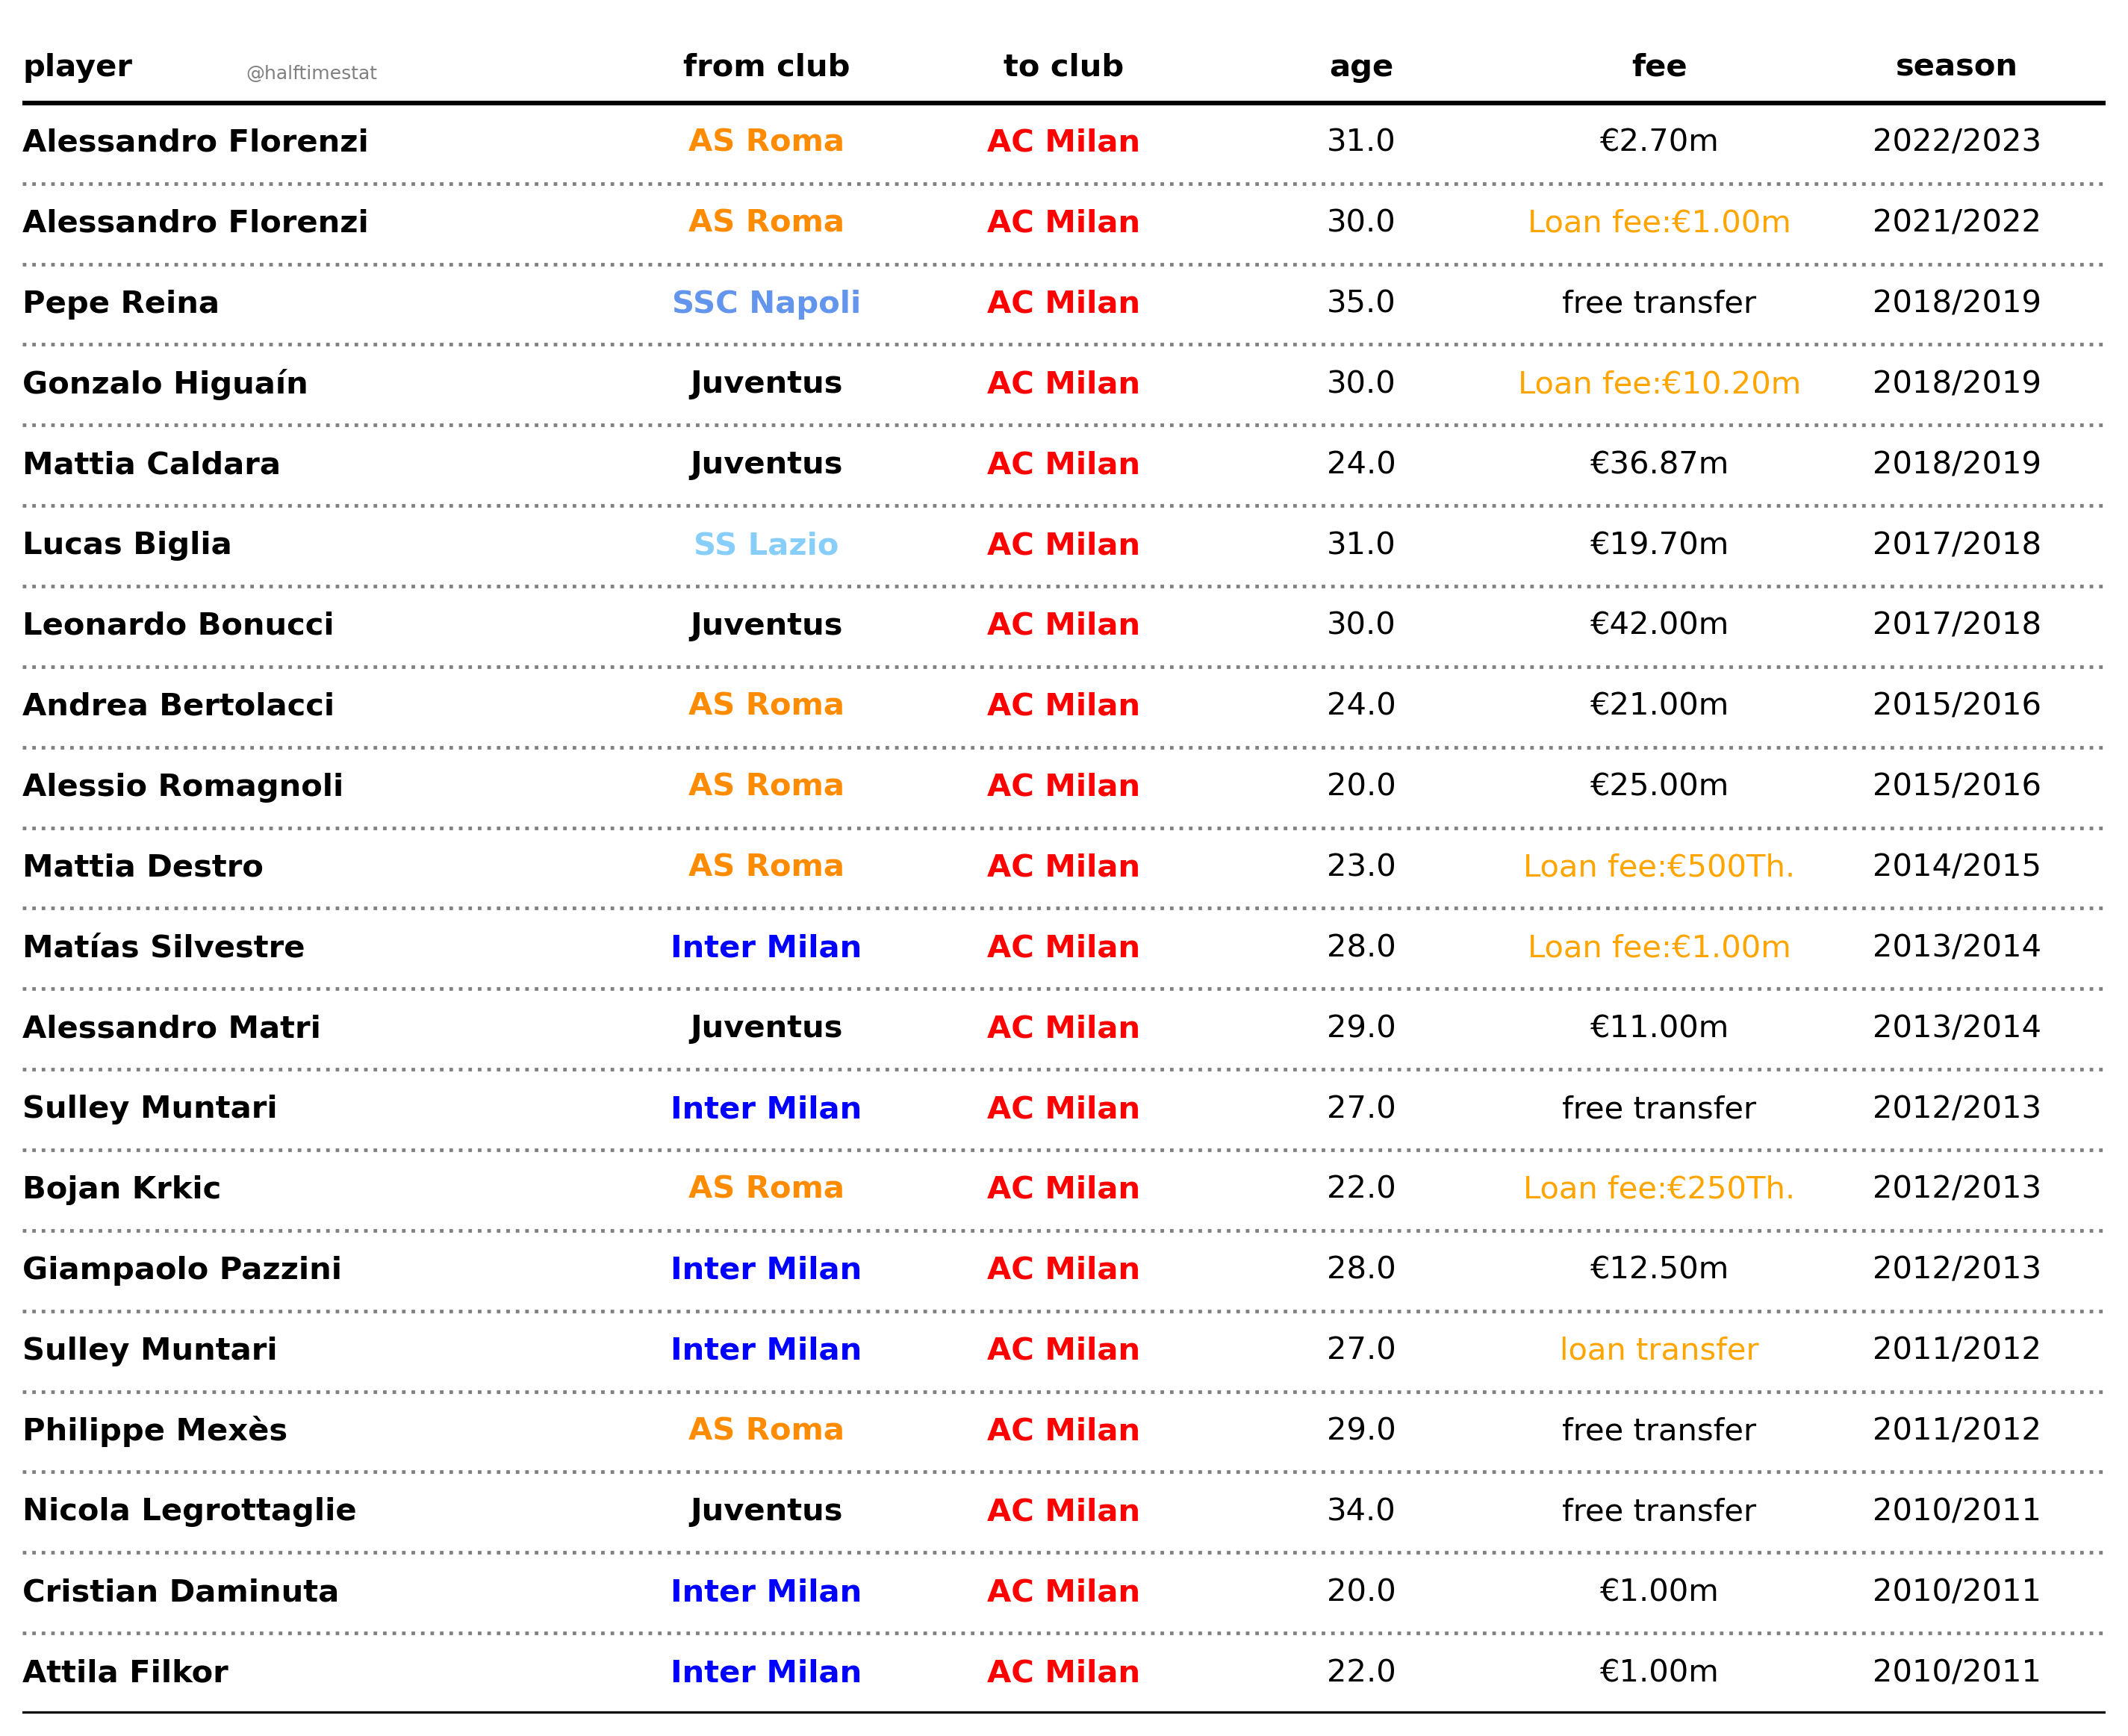

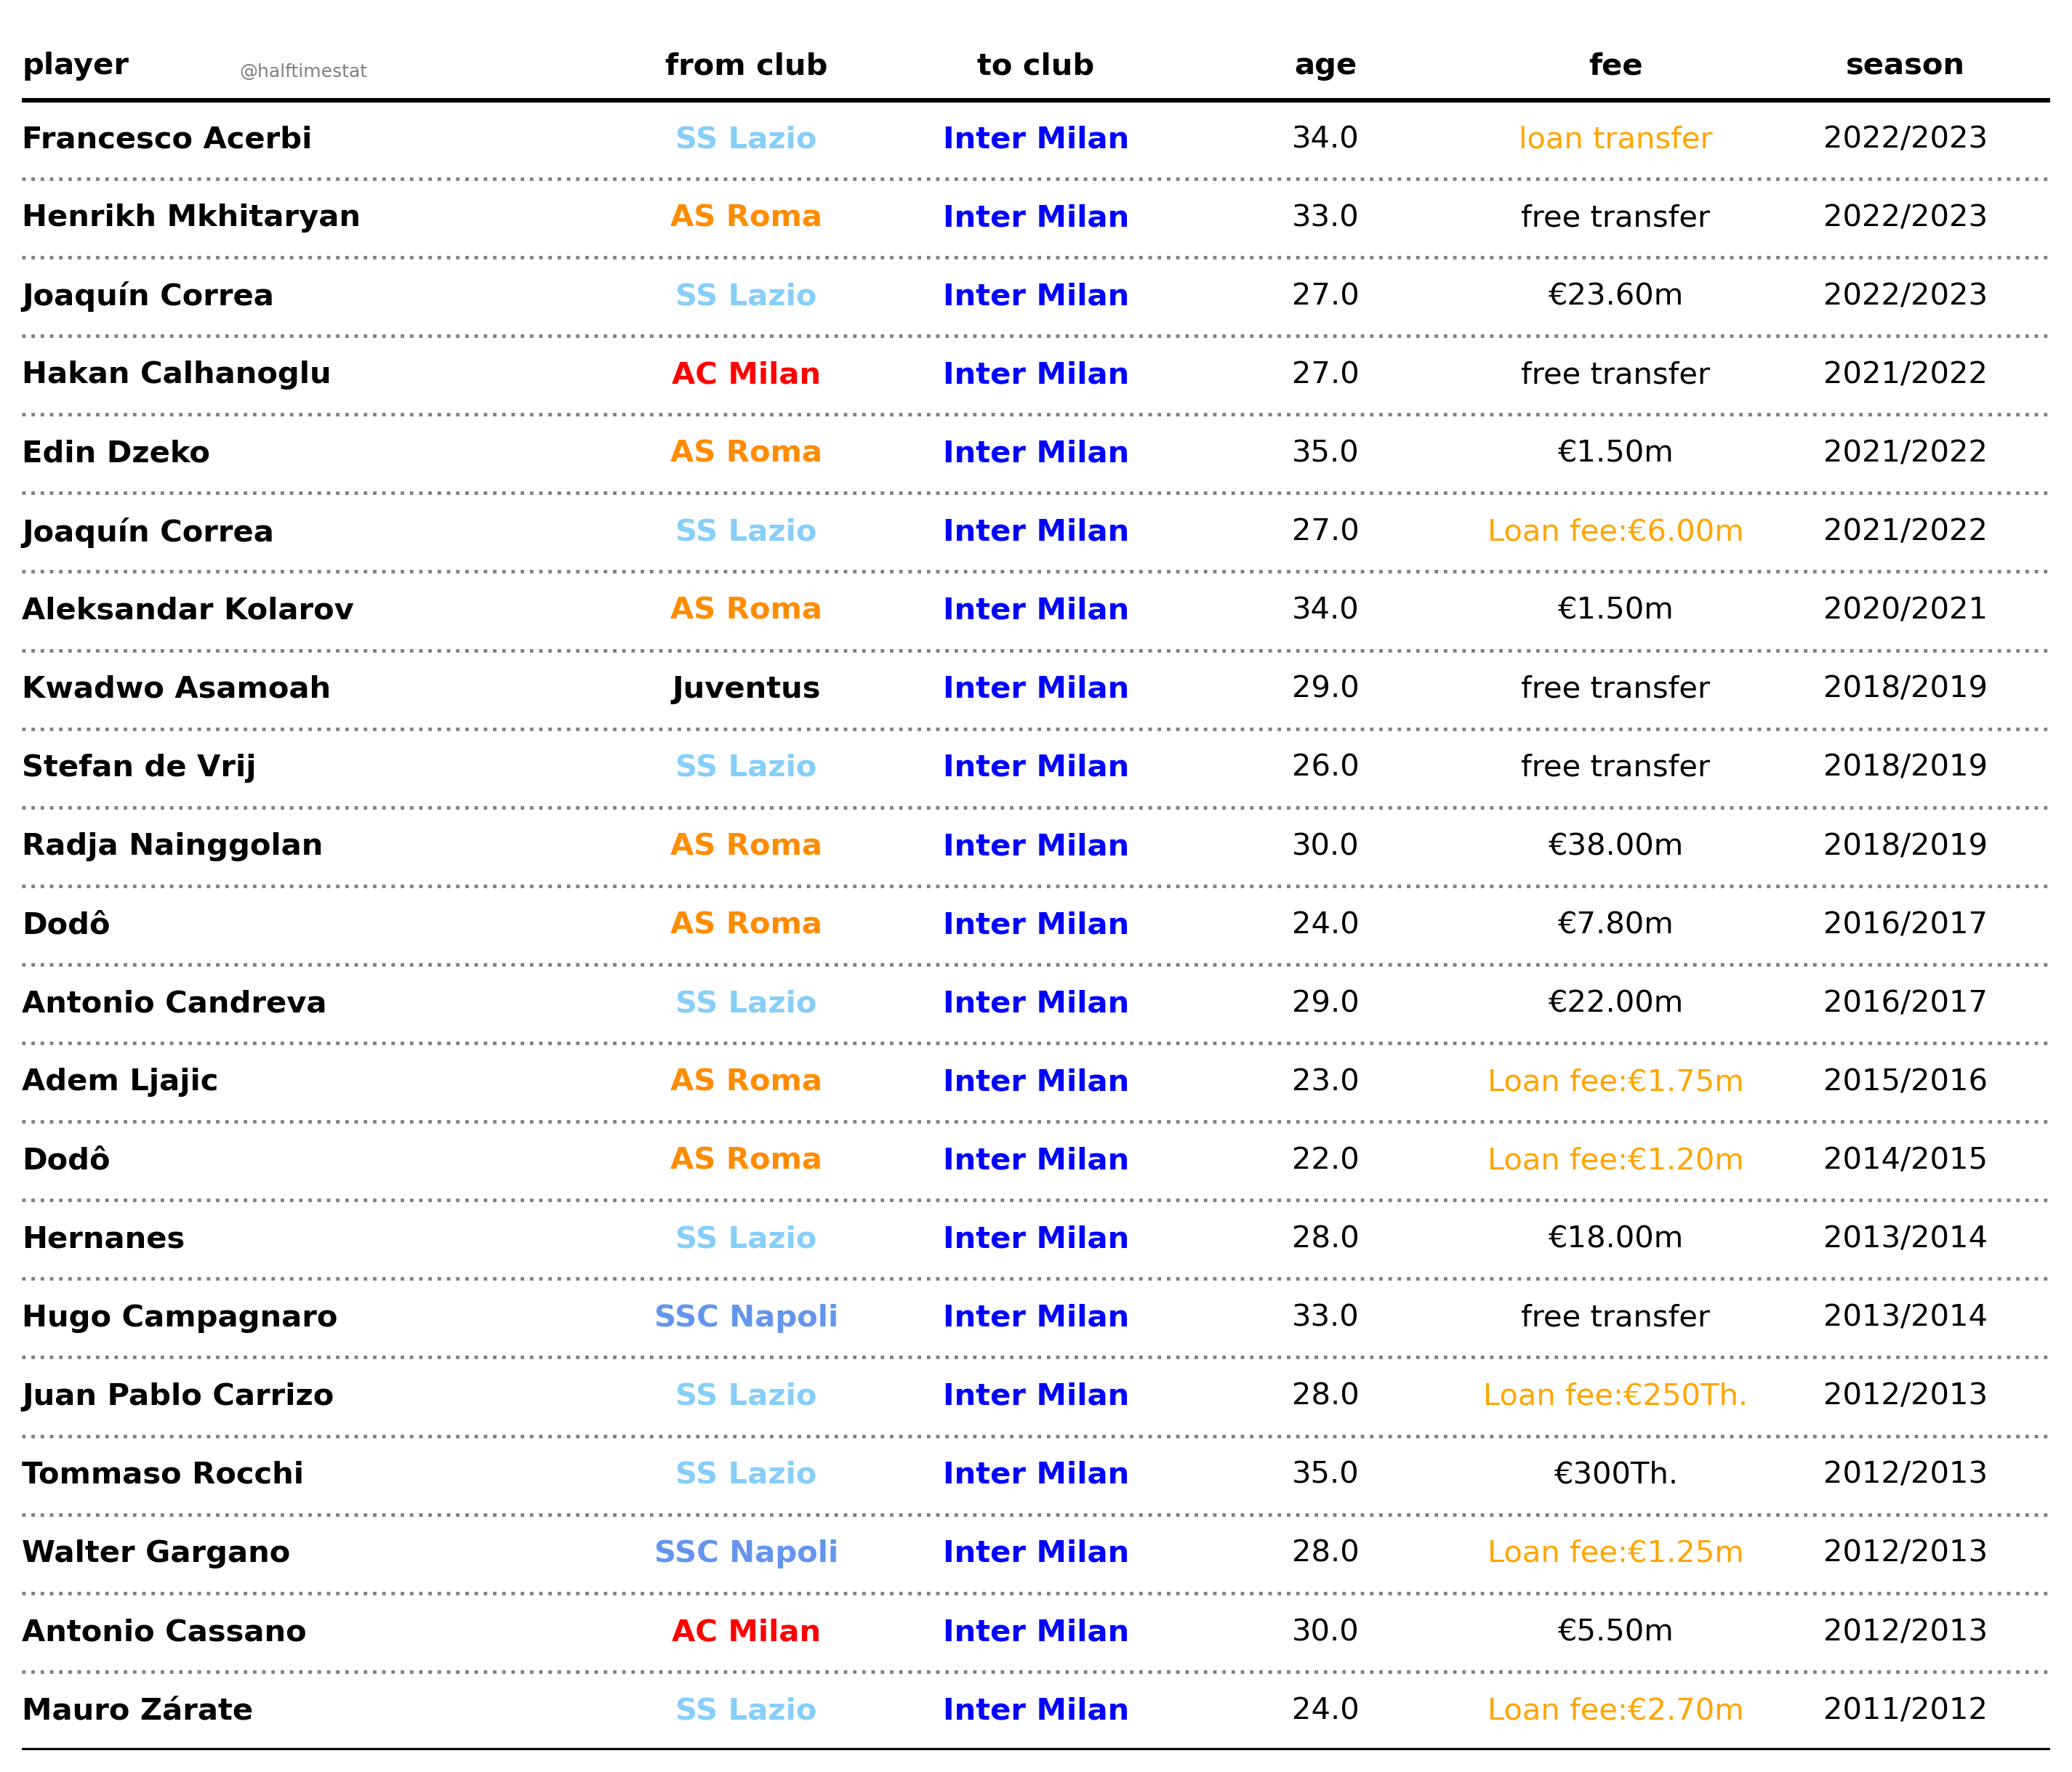

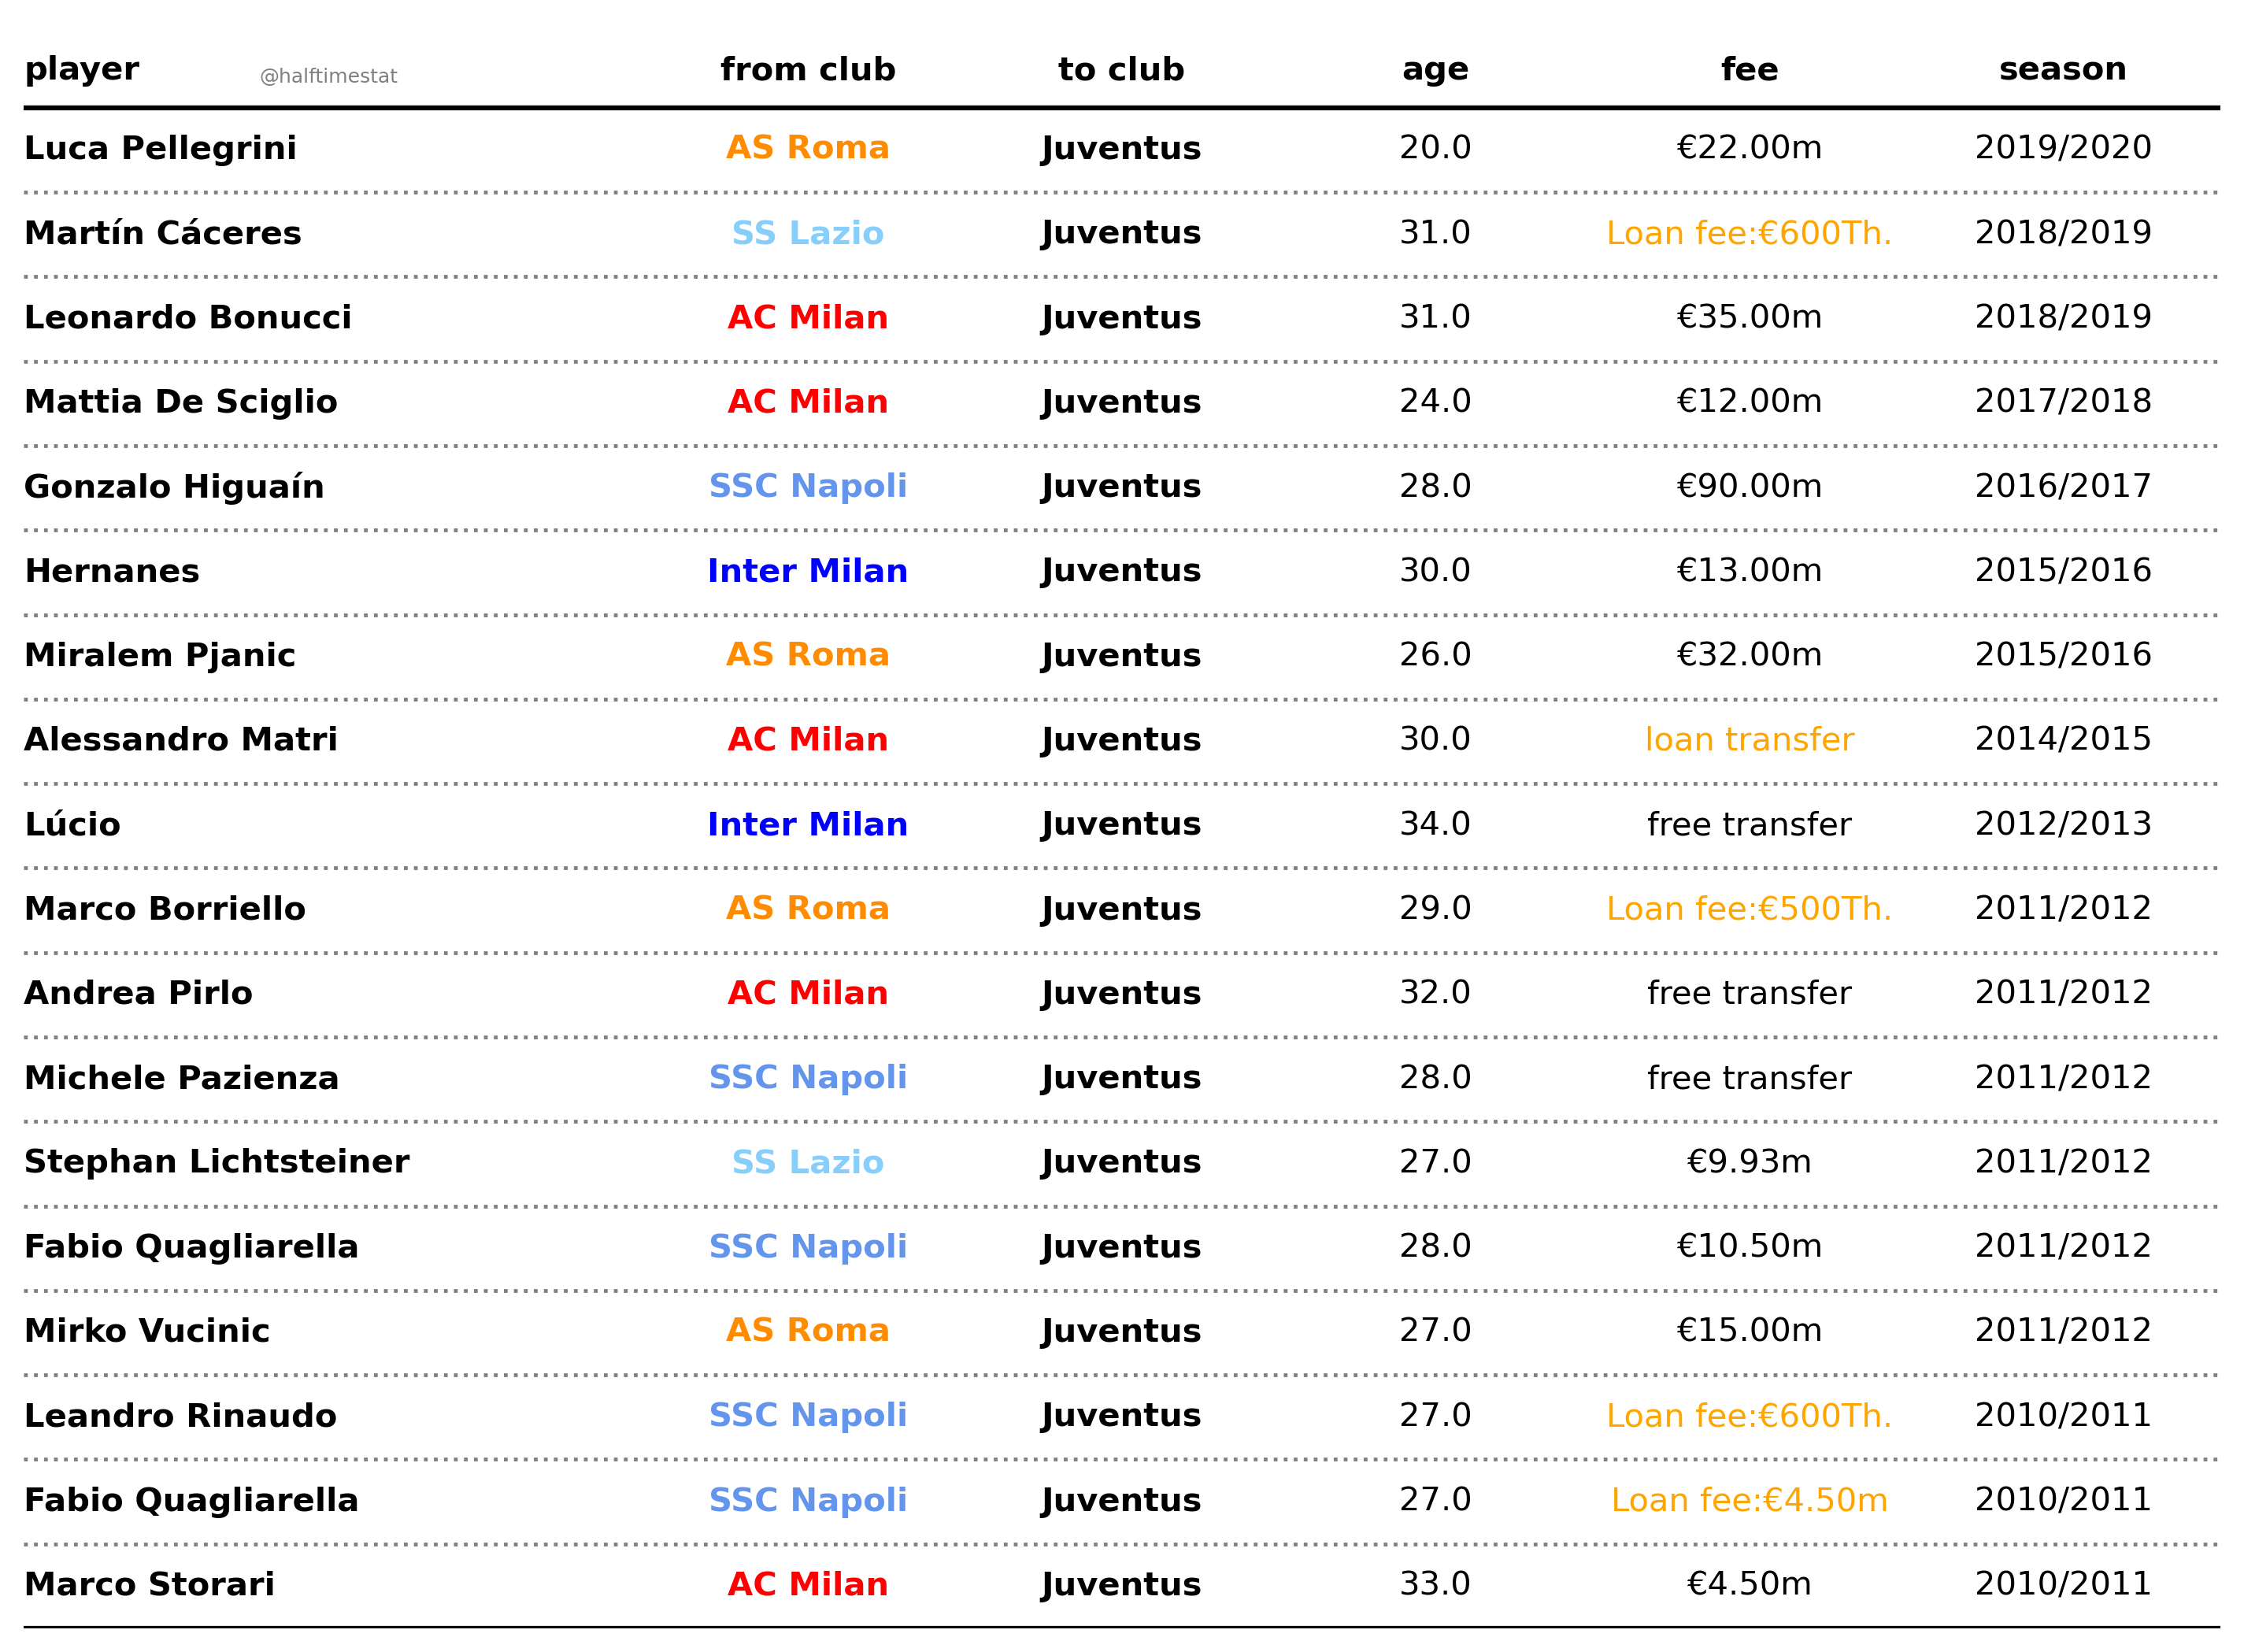

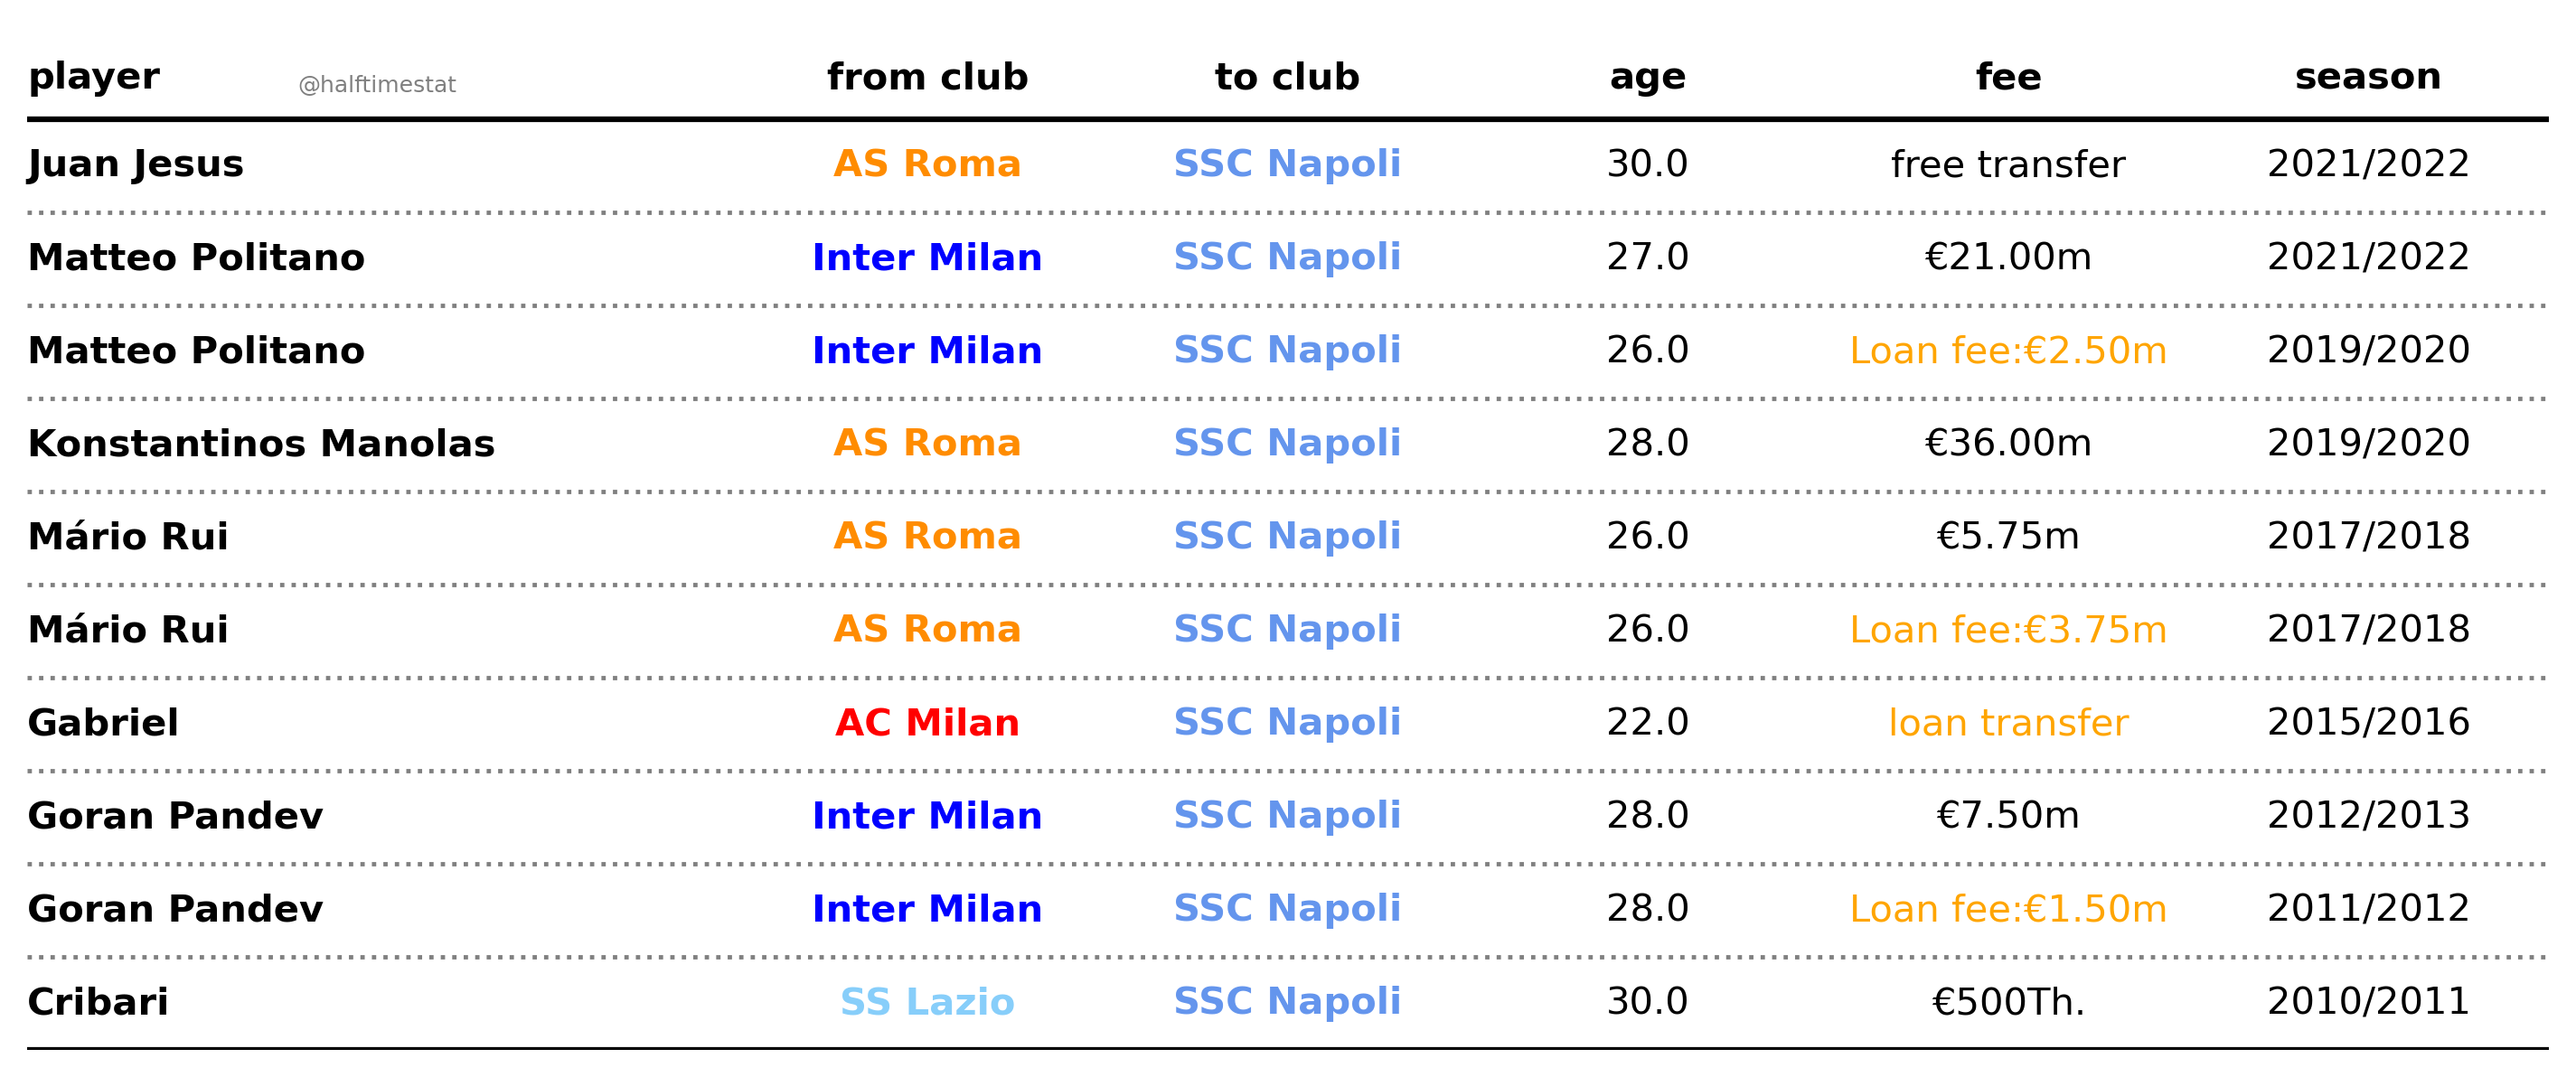

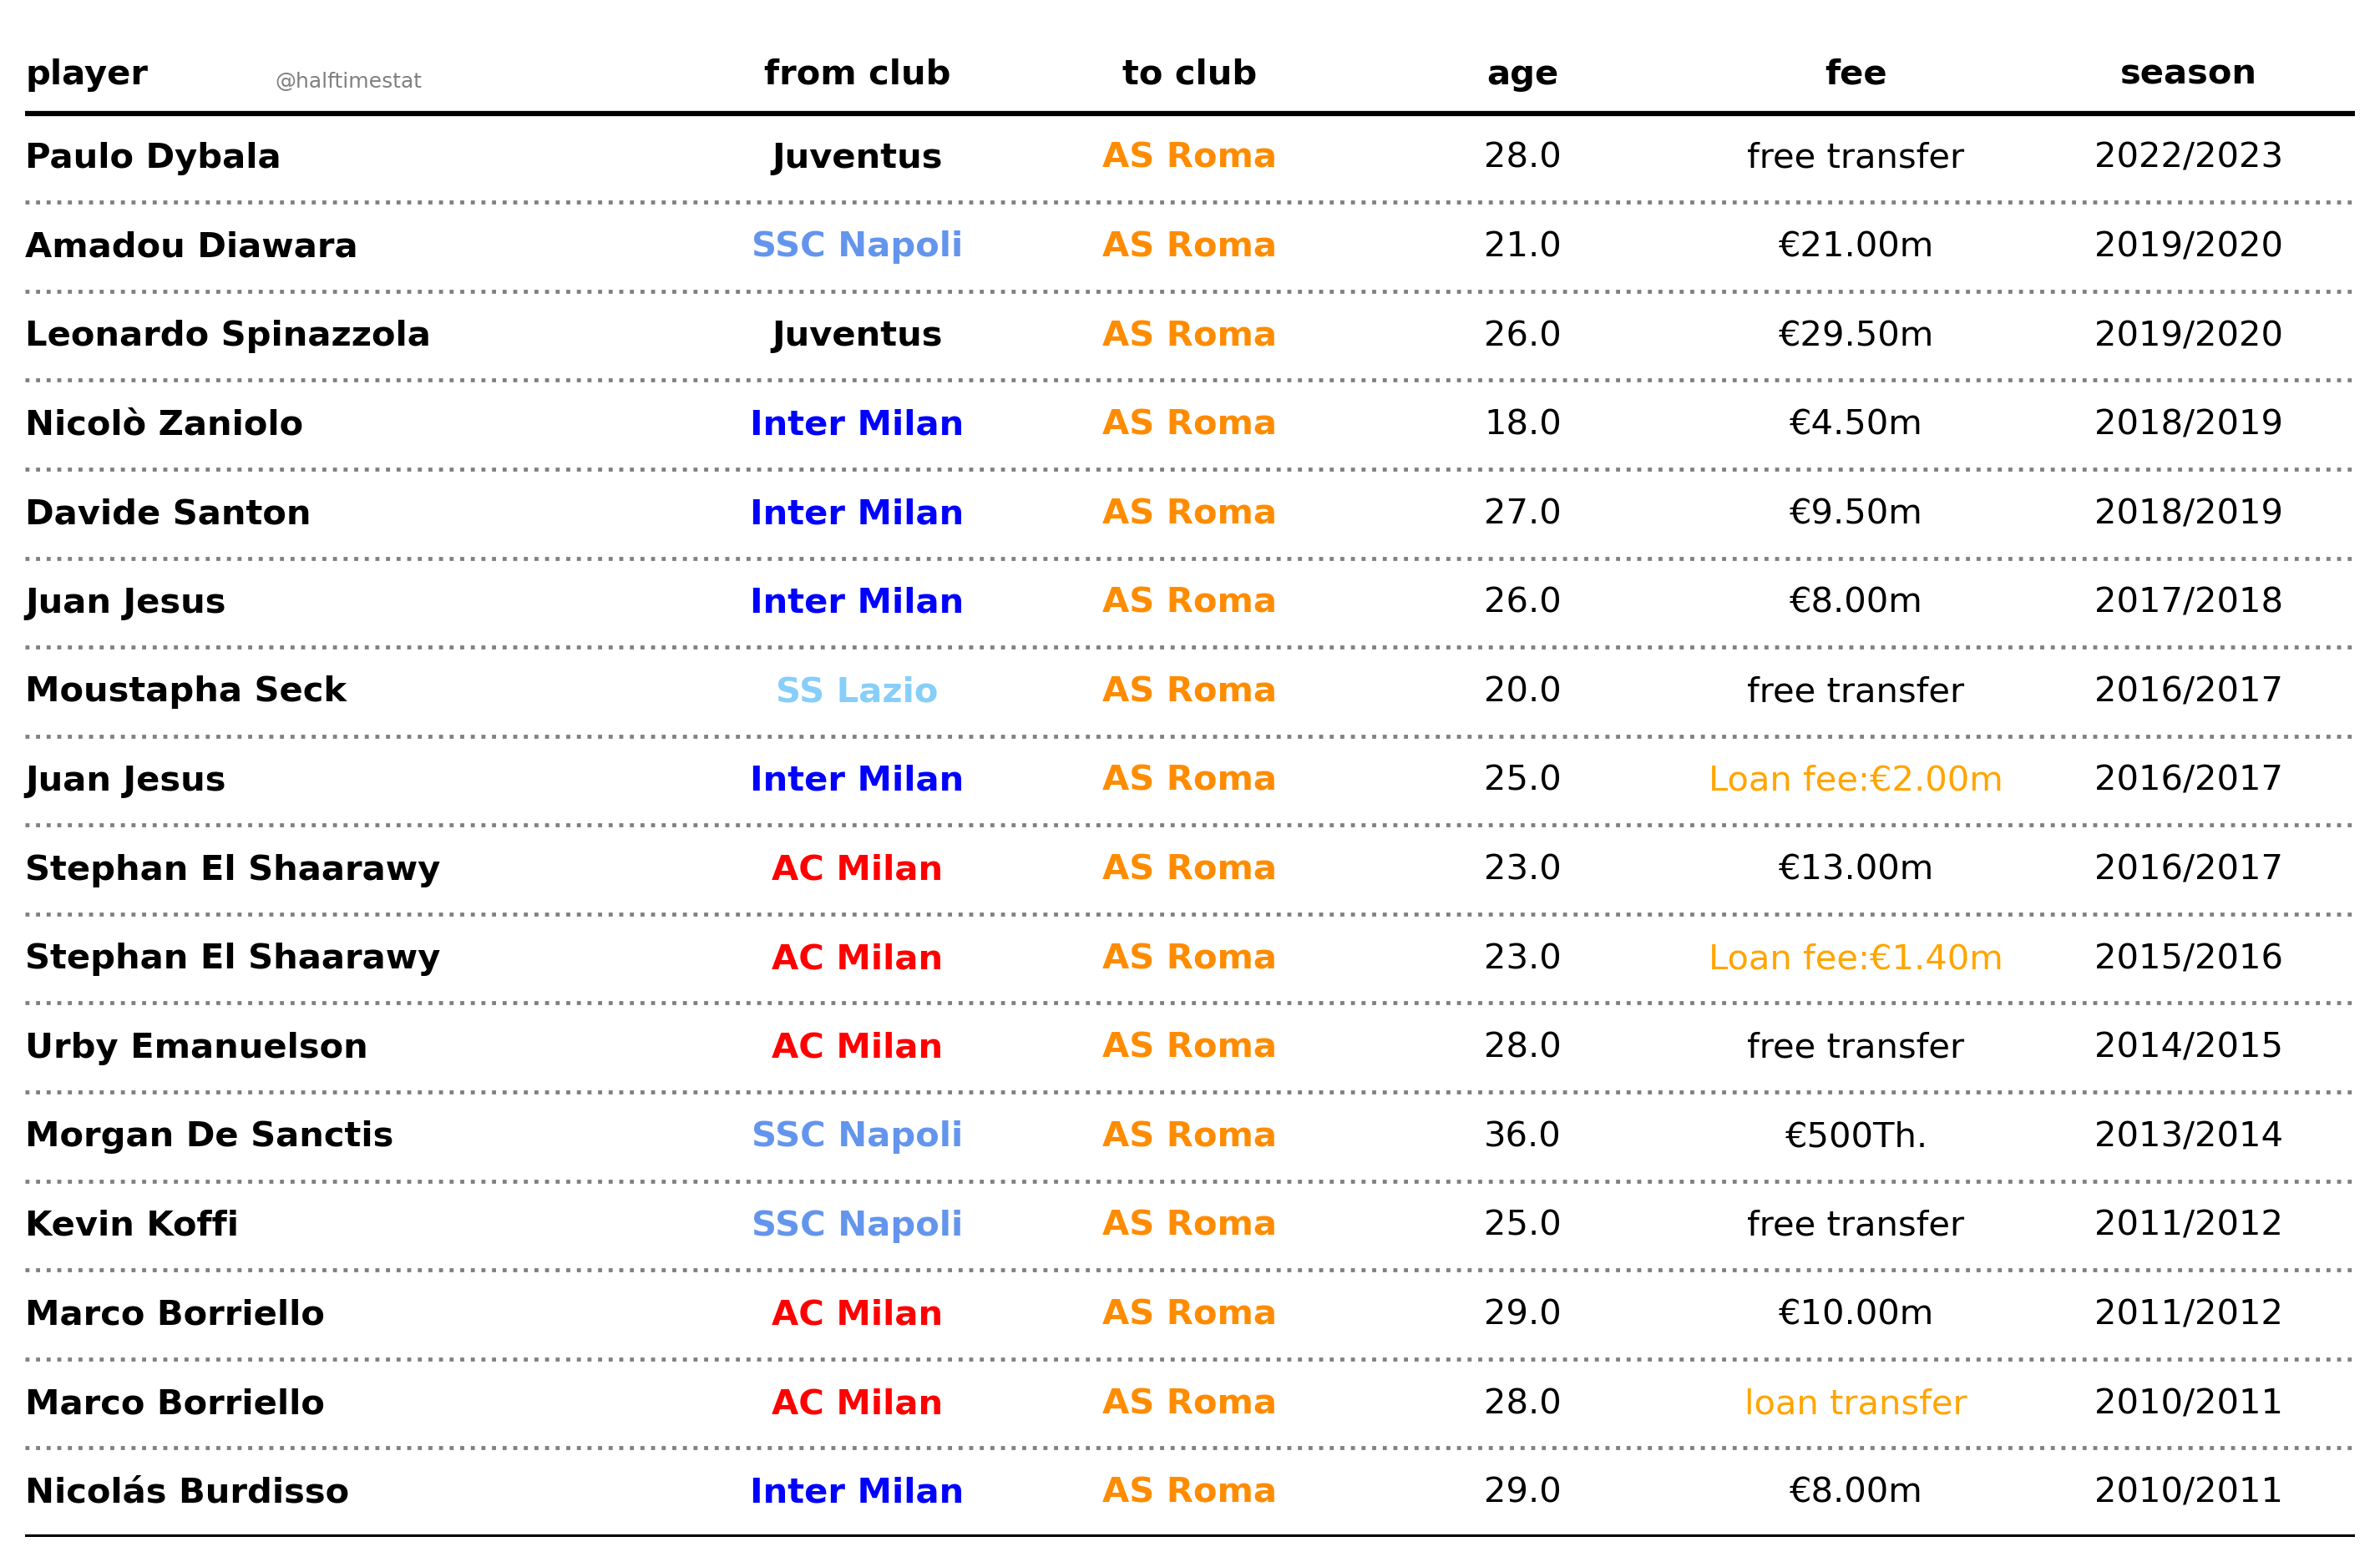

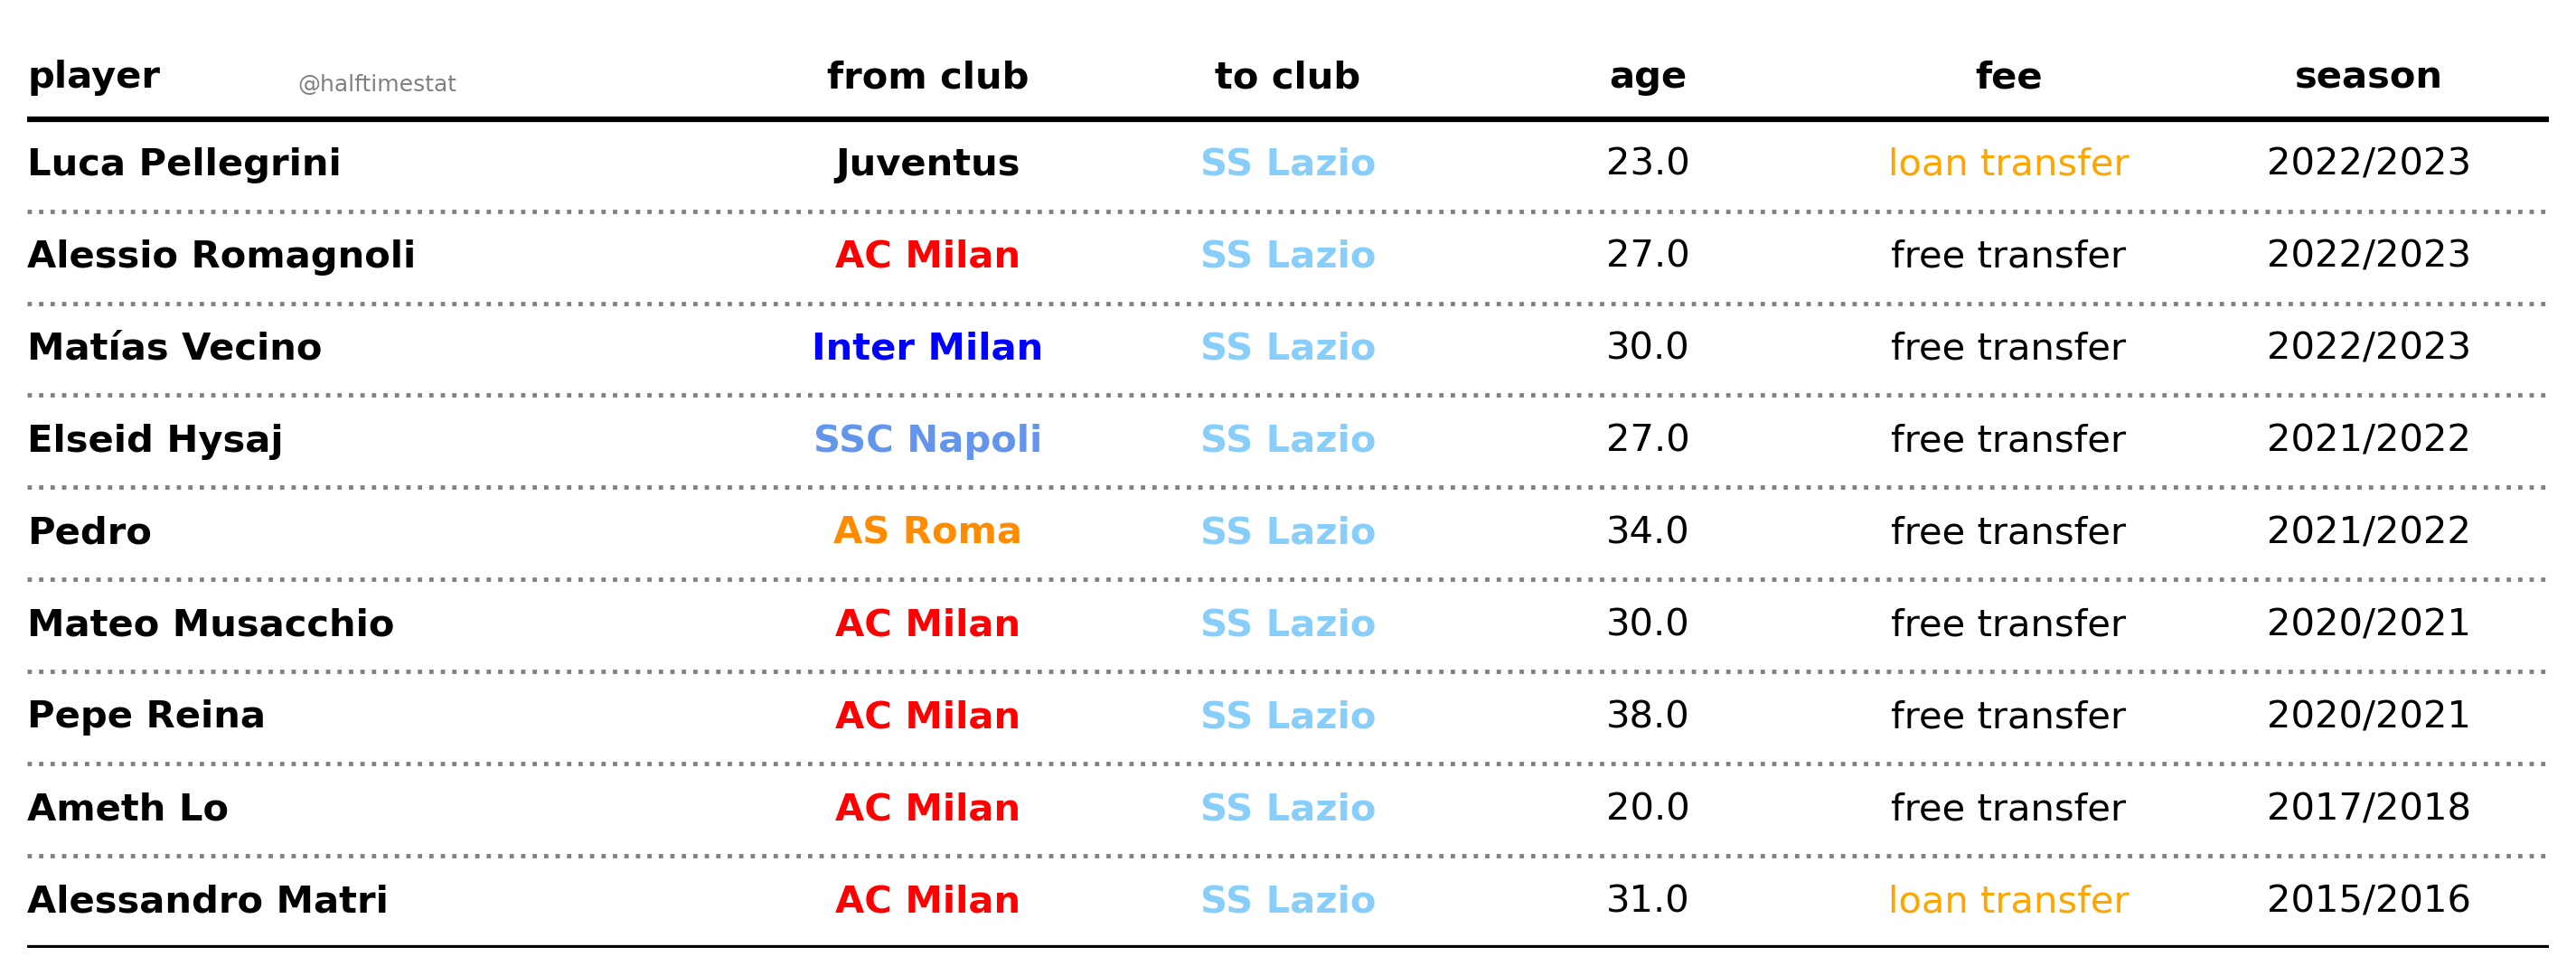

In [35]:
for club_i in range(len(big6_clubs)):
    display_df = transf_df_big6[transf_df_big6.club_name==big6_clubs[club_i]][display_cols]
    display_df = display_df.rename(
        columns={'player_name': 'player', 'club_name': 'to club', 'club_involved_name': 'from club'}
    )

    
    ### PRETTY TABLE
    ncols = display_df.shape[1]
    nrows = display_df.shape[0]

    fig = plt.figure(figsize=(12,0.5*nrows), dpi=300)
    ax = plt.subplot()

    ax.set_xlim(0, ncols + 1)
    ax.set_ylim(0, nrows + 1)

    positions = [0, 2.5] + list(np.arange(3.5, 3.5+1*(ncols-1), 1))
    columns = display_df.columns

    club_color_d = {
        'Juventus': 'black', 'AC Milan': 'red', 'Inter Milan': 'blue', 
        'AS Roma': 'darkorange', 'SS Lazio': 'lightskyblue', 'SSC Napoli': 'cornflowerblue',
    }

    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'left'
            else:
                ha = 'center'

            text_label = display_df[column].iloc[i]
            color = 'black'
            if 'club' in column or column=='player':
                weight = 'bold'

                if 'club' in column:
                    color = club_color_d[display_df[column].iloc[i]]
            else:
                weight = 'normal'

                if column=='fee' and 'loan' in display_df[column].iloc[i].lower():
                    color='orange'


            # print(positions[j], i + .5)
            ax.annotate(
                xy=(positions[j], i + .5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight,
                color=color
            )


    # Add column names
    column_names = columns
    for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
            ax.annotate(
                xy=(positions[index]+0.75, nrows+.25), text='@halftimestat', 
                ha='left', va='bottom', weight='normal', color='grey', fontsize=6
            )
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
    )

    # Add dividing lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    ax.set_axis_off()

In [ ]:
# https://dreampuf.github.io/GraphvizOnline/#digraph%20G%20%7B%0A%0A%20%20subgraph%20cluster_0%20%7B%0A%20%20%20%20style%3Dfilled%3B%0A%20%20%20%20color%3Dlightgrey%3B%0A%20%20%20%20node%20%5Bstyle%3Dfilled%2Ccolor%3Dwhite%5D%3B%0A%20%20%20%20%2F%2F%20%22AC%20Milan%22-%3E%22Inter%20Milan%22-%3E%22Juventus%22-%3E%22SSC%20Napoli%22-%3E%22AS%20Roma%22-%3E%22SS%20Lazio%22%3B%0A%20%20%20%20label%20%3D%20%22process%20%231%22%3B%0A%20%20%7D%0A%20%20%22Inter%20Milan%22-%3E%22AC%20Milan%22%3B%0A%20%20%22Juventus%22-%3E%22AC%20Milan%22%3B%0A%20%20%22SSC%20Napoli%22-%3E%22AC%20Milan%22%3B%0A%20%20%22AS%20Roma%22-%3E%22AC%20Milan%22%3B%0A%20%20%22SS%20Lazio%22-%3E%22AC%20Milan%22%3B%0A%20%20%0A%20%20%22AC%20Milan%22-%3E%22Inter%20Milan%22%3B%0A%20%20%22Juventus%22-%3E%22Inter%20Milan%22%3B%0A%20%20%22SSC%20Napoli%22-%3E%22Inter%20Milan%22%3B%0A%20%20%22AS%20Roma%22-%3E%22Inter%20Milan%22%3B%0A%20%20%22SS%20Lazio%22-%3E%22Inter%20Milan%22%3B%0A%20%20%0A%20%20%22AC%20Milan%22-%3E%22Juventus%22%3B%0A%20%20%22Inter%20Milan%22-%3E%22Juventus%22%3B%0A%20%20%22SS%20Lazio%22-%3E%22Juventus%22%3B%0A%20%20%22SSC%20Napoli%22-%3E%22Juventus%22%3B%0A%20%20%22AS%20Roma%22-%3E%22Juventus%22%3B%0A%20%20%0A%20%20%0A%20%20%22AC%20Milan%22-%3E%22SSC%20Napoli%22%3B%0A%20%20%22Inter%20Milan%22-%3E%22SSC%20Napoli%22%3B%0A%20%20%22AS%20Roma%22-%3E%22SSC%20Napoli%22%3B%0A%20%20%22SS%20Lazio%22-%3E%22SSC%20Napoli%22%3B%0A%20%20%0A%20%20%22AC%20Milan%22-%3E%22AS%20Roma%22%3B%0A%20%20%22Juventus%22-%3E%22AS%20Roma%22%3B%0A%20%20%22SSC%20Napoli%22-%3E%22AS%20Roma%22%3B%0A%20%20%22Inter%20Milan%22-%3E%22AS%20Roma%22%3B%0A%20%20%22SS%20Lazio%22-%3E%22AS%20Roma%22%3B%0A%20%20%0A%20%20%22AC%20Milan%22-%3E%22SS%20Lazio%22%3B%0A%20%20%22Inter%20Milan%22-%3E%22SS%20Lazio%22%3B%0A%20%20%22Juventus%22-%3E%22SS%20Lazio%22%3B%0A%20%20%22SSC%20Napoli%22-%3E%22SS%20Lazio%22%3B%0A%20%20%22AS%20Roma%22-%3E%22SS%20Lazio%22%3B%0A%7D

transf_df_big6[['club_involved_name', 'club_name']].value_counts()

## The Lazio Paradox

In [26]:
FOLDER_PATH = '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/'

seriea_df = pd.read_csv(FOLDER_PATH+'/2022-2023-Serie-A_Outfield.csv')
seriea_gk = pd.read_csv(FOLDER_PATH+'2022-2023-Serie-A_Keepers.csv')
seriea_clubs = pd.read_csv(FOLDER_PATH+'2022-2023-Serie-A_Teams.csv')
seriea_clubs_vs = pd.read_csv(FOLDER_PATH+'2022-2023-Serie-A_Teams_VS.csv')

In [51]:
[x for x in seriea_clubs.columns if 'xg' in x.lower()]
[x for x in seriea_gk.columns if 'save' in x.lower()]
[x for x in seriea_df.columns if 'xg' in x.lower()]

['xg',
 'npxg',
 'xg_assist',
 'npxg_xg_assist',
 'xg_per90',
 'xg_assist_per90',
 'xg_xg_assist_per90',
 'npxg_per90',
 'npxg_xg_assist_per90',
 'npxg_per_shot',
 'xg_net',
 'npxg_net',
 'xg_assist_net']

In [52]:
# seriea_gk[['player','minutes_90s','gk_goals_against','gk_psxg','gk_psxg_net', 'gk_save_pct']
#          ].sort_values('gk_save_pct')

# seriea_df[seriea_df.team=='Lazio'][['player','minutes_90s','goals','npxg','npxg_net']
#          ].sort_values('npxg_net')

In [53]:
# seriea_df.sort_values('npxg_net', ascending=False).reset_index().head(20)

# seriea_clubs['xg_diff'] = seriea_clubs['xg'] - seriea_clubs['gk_psxg']
# seriea_clubs.sort_values('gk_psxg')
# seriea_clubs.sort_values('xg_diff', ascending=False)

In [43]:
x_feat = 'gk_psxg_net'
y_feat = 'gk_goals_against'
df_filtered = seriea_gk[
    seriea_gk['minutes_90s']>15
]

fig = px.scatter(
    df_filtered, x=x_feat, y=y_feat, custom_data=['player'], color='gk_save_pct',
    size=df_filtered['minutes_90s'] - 0.75*min(df_filtered['minutes_90s']),
    title='Serie A Goalkeepers, 22/23', template='none',
    labels={'gk_psxg_net': 'post-shot xG — actual goals allowed',
            'gk_goals_against':'goals allowed',
            'gk_save_pct': 'Save %',}
)
### hover text — add player name
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "player: %{customdata[0]}",
    ])
)

######################################################
###### OUTLIERS NEED TO BE SUBSCRIPTED MANUALLY ######
######################################################

### outliers citing
outliers = df_filtered.loc[
    (df_filtered.player.str.contains('Provedel')) |
    (df_filtered.player.str.contains('Sepe')) |
    (df_filtered.player.str.contains('Vicario')) |
    (df_filtered.player.str.contains('Montip')) |
    (df_filtered.player.str.contains('Consigli')) |
    (df_filtered.player.str.contains('Silvestri')) |
    (df_filtered.player.str.contains('Patr')) |
    (df_filtered.player.str.contains('Maignan')),
    
    ['player', x_feat, y_feat]
]

### add text to outliers using their (x,y) coordinates:
for p,x,y in outliers.itertuples(index=False):
    x_shift = 0
    y_shift = -20
    if 'Foyth' in p or 'Koch' in p or 'Reinil' in p:
        y_shift=17.5
    if 'Amartey' in p:
        y_shift=-30

    fig.add_annotation(
        x=x, y=y,
        text=p,
        showarrow=False,
        xshift=x_shift,
        yshift=y_shift
    )


fig.update_layout(font=dict(size=14))
fig.add_annotation(
    x=0.05, y=0.15, xref='paper', yref='paper',
    text='Circle size indicates <br><b>minutes played by player</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"),
    align="center", bgcolor="bisque", opacity=0.75)

fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

## The art of fouls

In [10]:
FOLDER_PATH = '/Users/daviddramb/Downloads/[HTS]/SCOUTING_FOLDER/'
big_clubs = pd.DataFrame()
big_players = pd.DataFrame()
season_str = '2023-2024-' # '2022-2023-'

for league in ['Premier-League', 'La-Liga', 'Bundesliga', 'Serie-A', 'Ligue-1']:
    league_clubs = pd.read_csv(FOLDER_PATH+season_str+league+'_Teams.csv')
    league_clubs['league'] = league
    
    league_players = pd.read_csv(FOLDER_PATH+season_str+league+'_Outfield.csv')
    league_players['league'] = league
    
    big_clubs = pd.concat([big_clubs, league_clubs], axis=0)
    big_players = pd.concat([big_players, league_players], axis=0)

In [11]:
display_df = big_clubs[['squad', 'league', 'cards_yellow', 'cards_red', 'cards_yellow_red', 'fouls']].copy()
display_df['cards_straight_red'] = display_df['cards_red'] - display_df['cards_yellow_red']
display_df['cards_total'] = display_df['cards_yellow'] + display_df['cards_straight_red']

display_df['fouls_per_yellow'] = display_df['fouls'] / display_df['cards_yellow']
display_df['fouls_per_red'] = display_df['fouls'] / display_df['cards_red']
display_df['fouls_per_card'] = display_df['fouls'] / display_df['cards_total']

In [17]:
x_feat = 'fouls_per_card'
y_feat = 'fouls'


fig = px.scatter(
    display_df, x=x_feat, y=y_feat, custom_data=['squad'], color='league',
    size='cards_total', # size=df_filtered['minutes_90s'] - 0.75*min(df_filtered['minutes_90s']),
    title='BIG 5 Leagues and Cards, 23/24', template='none',
    labels={'fouls': 'fouls per season', 'fouls_per_card':'fouls per yellow or red card', 'league': '',}
)
### hover text — add player name
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "squad: %{customdata[0]}",
    ])
)



######################################################
###### OUTLIERS NEED TO BE SUBSCRIPTED MANUALLY ######
######################################################

### outliers citing
outliers = display_df.loc[
    (display_df.squad.str.contains('Arsenal')) |
    (display_df.squad.str.contains('Bournemouth')) |
    (display_df.squad.str.contains('Reims')) |
    (display_df.squad.str.contains('Metz')) |
    (display_df.squad.str.contains('Bayern')) |
    (display_df.squad.str.contains('Strasbourg')) |
    (display_df.squad.str.contains('Inter')) |
    (display_df.squad.str.contains('Rayo Vallecano')) |
    (display_df.squad.str.contains('Cádiz')) |
    (display_df.squad.str.contains('Chelsea')) |
    (display_df.squad.str.contains('Mallorca')) |
    (display_df.squad.str.contains('Getafe')) |
    (display_df.squad.str.contains('Real Sociedad')),
    
    ['squad', x_feat, y_feat]
]

### add text to outliers using their (x,y) coordinates:
for p,x,y in outliers.itertuples(index=False):
    x_shift = 0
    y_shift = -20
    if 'Reims' in p or 'Mallorca' in p or 'Chelsea' in p or 'Arsenal' in p:
        y_shift=20

    fig.add_annotation(
        x=x, y=y,
        text=p,
        showarrow=False,
        xshift=x_shift,
        yshift=y_shift
    )




fig.update_layout(font=dict(size=14))
fig.add_annotation(
    x=1.005, y=0.975, xref='paper', yref='paper',
    text='Circle size indicates<br><b>total amount of cards</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"),
    align="center", bgcolor="bisque", opacity=0.75)

fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

In [18]:
display_df.sort_values('cards_total', ascending=False)

,squad,league,cards_yellow,cards_red,cards_yellow_red,fouls,cards_straight_red,cards_total,fouls_per_yellow,fouls_per_red,fouls_per_card
8,Getafe,La-Liga,66.0,5.0,3.0,256.0,2.0,68.0,3.878788,51.200000,3.764706
6,Cádiz,La-Liga,49.0,5.0,0.0,247.0,5.0,54.0,5.040816,49.400000,4.574074
6,Chelsea,Premier-League,51.0,3.0,2.0,188.0,1.0,52.0,3.686275,62.666667,3.615385
16,Sheffield Utd,Premier-League,48.0,2.0,2.0,178.0,0.0,48.0,3.708333,89.000000,3.708333
19,Wolves,Premier-League,47.0,3.0,2.0,200.0,1.0,48.0,4.255319,66.666667,4.166667
...,...,...,...,...,...,...,...,...,...,...,...
13,Paris S-G,Ligue-1,18.0,1.0,0.0,137.0,1.0,19.0,7.611111,137.000000,7.210526
8,Inter,Serie-A,19.0,0.0,0.0,153.0,0.0,19.0,8.052632,inf,8.052632
8,Metz,Ligue-1,17.0,1.0,0.0,162.0,1.0,18.0,9.529412,162.000000,9.000000
1,Bayern Munich,Bundesliga,17.0,1.0,0.0,120.0,1.0,18.0,7.058824,120.000000,6.666667


In [137]:
display_df = big_players[
    ['player', 'team', 'league', 'position', 'minutes_90s', 
     'cards_yellow', 'cards_red', 'cards_yellow_red', 'fouls']
].copy()
display_df['position_agg'] = display_df['position'].apply(lambda x: x[:x.find(',')] if x.find(',')!=-1 else x)

display_df['cards_straight_red'] = display_df['cards_red'] - display_df['cards_yellow_red']
display_df['cards_total'] = display_df['cards_yellow'] + display_df['cards_straight_red']

display_df['fouls_per_yellow'] = display_df['fouls'] / display_df['cards_yellow']
display_df['fouls_per_red'] = display_df['fouls'] / display_df['cards_red']
display_df['fouls_per_card'] = display_df['fouls'] / display_df['cards_total']

display_df['cards_per_foul'] = display_df['cards_total'] / display_df['fouls']


display_df = display_df[
#     (display_df['minutes_90s']>25)
    (display_df['fouls']>20)
#     :
]

In [138]:
# display_df[display_df.team=='Manchester City']
# display_df[display_df.team=='Chelsea']

# display_df[display_df.team=='Sevilla'].sort_values('fouls', ascending=False)

In [139]:
x_feat = 'cards_per_foul' # 'fouls_per_card' # 'cards_total' # 'fouls_per_card'
y_feat = 'fouls'

fig = px.scatter(
    display_df, x=x_feat, y=y_feat, custom_data=['player'], color='position_agg', # color='league',
    size='cards_total', opacity=0.5,
    title='BIG 5 Leagues and Cards, 22/23', template='none',
    labels={'fouls': 'fouls per season', 'cards_per_foul':'yellow or red cards per foul', 'position_agg': 'position',}
)
### hover text — add player name
fig.update_traces(
    hovertemplate="<br>".join([
        x_feat+": %{x}",
        y_feat+": %{y}",
        "player: %{customdata[0]}",
    ])
)



######################################################
###### OUTLIERS NEED TO BE SUBSCRIPTED MANUALLY ######
######################################################

### outliers citing
outliers = display_df.loc[
    (display_df.player.str.contains('Manchester City')) |
    (display_df.player.str.contains('West Ham')) |
    (display_df.player.str.contains('Real Sociedad')),
    
    ['player', x_feat, y_feat]
]

### add text to outliers using their (x,y) coordinates:
for p,x,y in outliers.itertuples(index=False):
    x_shift = 0
    y_shift = -20
    if 'Napoli' in p or 'Marseille' in p or 'Brighton' in p or 'Liverpool' in p:
        y_shift=20

    fig.add_annotation(
        x=x, y=y,
        text=p,
        showarrow=False,
        xshift=x_shift,
        yshift=y_shift
    )




fig.update_layout(font=dict(size=14))
fig.add_annotation(
    x=0.9, y=0.95, xref='paper', yref='paper',
    text='Circle size indicates<br><b>total amount of cards</b>', 
    showarrow=False, font=dict(family="Courier New, monospace", size=14, color="black"),
    align="center", bgcolor="bisque", opacity=0.75)

fig.add_annotation(x=1, y=1.07, xref='paper', yref='paper', text='@halftimestat', showarrow=False)
fig.show()

## Transfers between Granada, Udinese, Watford

In [82]:
transf_df = pd.DataFrame()
for league in ['serie-a', 'premier-league', 'championship', 'primera-division']:
    transf_league_df = pd.read_csv('./transfers_data/'+league+'.csv')
    
    transf_df = pd.concat([transf_df, transf_league_df], axis=0)
    

transf_df.loc[
    transf_df['club_involved_name'].str.lower().str.contains('watford'),'club_involved_name'
] = 'Watford FC'
transf_df.loc[
    transf_df['club_involved_name'].str.lower().str.contains('udinese'),'club_involved_name'
] = 'Udinese Calcio'


transf_df = transf_df[~transf_df['fee'].fillna('?').str.contains('End of loan')]
# transf_df[transf_df['club_name'].str.lower().str.contains('gran')]['club_name'].unique()
# transf_df[transf_df['club_involved_name'].str.lower().str.contains('granada')]['club_involved_name'].unique()

In [83]:
# transf_df[
#     (transf_df['club_name']=='Watford FC')&(transf_df['year']>=2012)&(transf_df['year']<=2015)
# ].year.unique()

# transf_df[
#     (transf_df['club_name']=='Granada CF')&(transf_df['year']>=2012)&(transf_df['year']<=2015)
# ].year.unique()

# transf_df[
#     (transf_df['club_name']=='Udinese Calcio')&(transf_df['year']>=2012)&(transf_df['year']<=2015)
# ].year.unique()

In [84]:
trio_df = transf_df[
    (transf_df['club_name'].isin(['Watford FC','Granada CF','Udinese Calcio'])) 
    | (transf_df['club_involved_name'].isin(['Watford FC','Granada CF','Udinese Calcio']))
]

In [95]:
trio_df[
    (trio_df['year']>=2012)&(trio_df['year']<=2015)
].groupby(
    ['club_name', 'club_involved_name', 'transfer_movement']
).count().sort_values('player_name', ascending=False).head(10)

,,,player_name,age,position,fee,transfer_period,fee_cleaned,league_name,year,season,country
club_name,club_involved_name,transfer_movement,,,,,,,,,,
Watford FC,Udinese Calcio,in,28,28,28,28,28,7,28,28,28,28
Udinese Calcio,Watford FC,out,28,28,28,28,28,7,28,28,28,28
Granada CF,Udinese Calcio,out,13,13,13,13,13,7,13,13,13,13
Udinese Calcio,Granada CF,in,13,13,13,13,13,7,13,13,13,13
Granada CF,Udinese Calcio,in,13,13,13,13,13,1,13,13,13,13
Udinese Calcio,Granada CF,out,12,12,12,12,12,1,12,12,12,12
Granada CF,Watford FC,out,9,9,9,9,9,2,9,9,9,9
Watford FC,Granada CF,in,9,9,9,9,9,2,9,9,9,9
Udinese Calcio,Perugia,out,9,9,9,9,9,0,9,9,9,9


In [97]:
trio_df[
   (trio_df['club_name']=='Watford FC')
    &(trio_df['club_involved_name']=='Udinese Calcio')
    
    &(trio_df['year']>=2016) 
].groupby(['transfer_movement']).count().sort_values('player_name', ascending=False).head(10)

,club_name,player_name,age,position,club_involved_name,fee,transfer_period,fee_cleaned,league_name,year,season,country
transfer_movement,,,,,,,,,,,,
out,18,18,18,18,18,18,18,10,18,18,18,18
in,11,11,11,11,11,11,11,3,11,11,11,11


In [100]:
trio_df[
   (trio_df['club_name']=='Udinese Calcio')
    &(trio_df['club_involved_name']=='Watford FC')
    
    &(trio_df['year']>=2016) 
].sort_values('fee_cleaned', ascending=False)

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,country
27777,Udinese Calcio,Hassane Kamara,28.0,Left-Back,Watford FC,€19.00m,in,Summer,19.0,Serie A,2022,2022/2023,Italy
26228,Udinese Calcio,Gerard Deulofeu,26.0,Centre-Forward,Watford FC,€17.00m,in,Winter,17.0,Serie A,2020,2020/2021,Italy
25218,Udinese Calcio,Ignacio Pussetto,24.0,Right Winger,Watford FC,€8.50m,out,Winter,8.5,Serie A,2019,2019/2020,Italy
27233,Udinese Calcio,Samir,27.0,Centre-Back,Watford FC,€5.00m,out,Winter,5.0,Serie A,2021,2021/2022,Italy
27779,Udinese Calcio,Adam Masina,28.0,Left-Back,Watford FC,€5.00m,in,Summer,5.0,Serie A,2022,2022/2023,Italy
22420,Udinese Calcio,Valon Behrami,32.0,Defensive Midfield,Watford FC,€2.00m,in,Summer,2.0,Serie A,2017,2017/2018,Italy
25216,Udinese Calcio,Marvin Zeegelaar,29.0,Left-Back,Watford FC,€2.00m,in,Winter,2.0,Serie A,2019,2019/2020,Italy
26740,Udinese Calcio,Isaac Success,25.0,Centre-Forward,Watford FC,€1.80m,in,Summer,1.8,Serie A,2021,2021/2022,Italy
23935,Udinese Calcio,Stefano Okaka,29.0,Centre-Forward,Watford FC,Loan fee:€500Th.,in,Winter,0.5,Serie A,2018,2018/2019,Italy
23937,Udinese Calcio,Marvin Zeegelaar,28.0,Left-Back,Watford FC,Loan fee:€300Th.,in,Winter,0.3,Serie A,2018,2018/2019,Italy


In [89]:
transf_df[
    (transf_df['club_name']=='Watford FC')
    &(transf_df['year']>=2012)
    &(transf_df['year']<=2015)
].groupby(['club_involved_name', 'transfer_movement']).count().sort_values('club_name', ascending=False).head(5)

,club_name,player_name,age,position,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,country
club_involved_name,,,,,,,,,,,,
Udinese Calcio,30,30,30,30,30,30,30,8,30,30,30,30
Without Club,14,14,14,14,14,14,14,0,14,14,14,14
Granada CF,11,11,11,11,11,11,11,2,11,11,11,11
Sheff Wed,5,5,5,5,5,5,5,2,5,5,5,5
Retired,4,4,4,4,4,4,4,0,4,4,4,4


In [45]:
transf_df[
    (transf_df['club_name']=='Granada CF')
    &(transf_df['year']>=2012)
    &(transf_df['year']<=2015)
].groupby(['club_involved_name', 'transfer_movement']).count().sort_values('club_name', ascending=False).head(5)

,,club_name,player_name,age,position,fee,transfer_period,fee_cleaned,league_name,year,season,country
club_involved_name,transfer_movement,,,,,,,,,,,
Udinese Calcio,out,28,28,28,28,28,28,7,28,28,28,28
Cádiz CF,in,15,15,15,15,15,15,0,15,15,15,15
Udinese Calcio,in,15,15,15,15,15,15,1,15,15,15,15
Watford,out,9,9,9,9,9,9,2,9,9,9,9
CD Lugo,out,6,6,6,6,6,6,3,6,6,6,6


In [43]:
transf_df[
    (transf_df['club_name']=='Udinese Calcio')
    &(transf_df['year']>=2012)
    &(transf_df['year']<=2015)
].groupby(['club_involved_name', 'transfer_movement']).count().sort_values('club_name', ascending=False).head(5)

club_name  player_name  age  position  \
club_involved_name transfer_movement                                          
Watford            out                       28           28   28        28   
Granada CF         out                       15           15   15        15   
                   in                        13           13   13        13   
Perugia            out                        9            9    9         9   
Juventus           out                        6            6    6         6   

                                      fee  transfer_period  fee_cleaned  \
club_involved_name transfer_movement                                      
Watford            out                 28               28            7   
Granada CF         out                 15               15            1   
                   in                  13               13            7   
Perugia            out                  9                9            0   
Juventus           out                  6                6            5   

                                      league_name  year  season  country  
club_involved_name transfer_movement                                      
Watford            out                         28    28      28       28  
Granada CF         out                         15    15      15       15  
                   in                          13    13      13       13  
Perugia            out                          9     9       9        9  
Juventus           out                          6     6       6        6